<a href="https://colab.research.google.com/github/dongyanl1n/PSL432-Theoretical-Physiology-A3/blob/master/TUNL%20FC%20Mem%205000x30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title import stuff
import gym
from gym import spaces
from gym.utils import seeding
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import autograd, optim, nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from numpy import array
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from itertools import compress
from matplotlib import gridspec
from scipy import stats
from tabulate import tabulate
from sklearn.decomposition import PCA

In [3]:
#@title define TUNL Env, AC net, and functions
class TunlEnv(object):
    def __init__(self, delay):
        """Trial-unique, delayed nonmatch-to-location (TUNL) task (Talpos et al., 2010)

        In each trial/episode, there are 5 stages:

        1. Initiation of sample phase: the agent will be given sound and light signal. In response, the agent must
        select the "initiate" action from the action space to proceed to sample phase. The trial will not proceed until
        the agent has selected the "initiate" action.

        2. Sample phase: the agent will be given one of two random samples: either left side (L) or the right side (R)
        of the touchscreen will be lit. The agent must poke the sample location on the touchscreen to proceed to the
        delay period. The trial will not proceed until the agent has poked the sample location.

        3. Delay: there will not be any stimulus during the delay period. The agent needs to memorize the sample during
        this period. Nothing that the agent does during delay period will have any consequences.

        4. Initiation of choice phase: after the delay period, the sound and light signal will be on again. In response,
        the agent must select the "initiate" action from the action space to proceed to choice phase. The trial will not
        proceed until the agent has selected the "initiate" action.

        5. Choice phase: the agent must choose the side of the touchscreen that was NOT lit in the sample phase
        (i.e. if the sample was L, the agent must select action R from action space). If agent correctly select the
        nonmatching action, it will receive a reward of 1. If the agent incorrectly select the matching action, it will
        receive a punishment (i.e. reward = -1). If the agent does not do anything meaningful, it will receive neither
        reward nor punishment (i.e, reward = 0). The L/R choices will stay on the touchscreen until the agent chooses
        the correct action.


        The observation space consists of 5 possible arrays, each with four elements: light, sound, L touchscreen, and
        R touchscreen. Each element is either 0 (off) or 1 on.
        [1,1,0,0] = light and sound on; this signals the animal to initiate sample / choice phase
        [0,0,1,0] = L touchscreen on
        [0,0,0,1] = R touchscreen on
        [0,0,0,0] = delay period, no signal
        [0,0,1,1] = both L and R touchscreen on; this signals the animal to make a choice

        The action space consists of 4 possible actions:
        0 = initiate
        1 = choose L on the touchscreen
        2 = choose R on the touchscreen
        3 = do nothing meaningful

        """
        self.observation = array([[1, 1, 0, 0]])
        self.sample = "undefined"
        self.episode_sample = None
        self.delay_t = 0  # time since delay
        self.delay_length = delay
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.MultiBinary(4)
        self.reward = 0
        self.done = False
        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        """
        :param action:
        :return: observation, reward, done, info
        """
        assert self.action_space.contains(action)
        if np.all(self.observation == array([[1, 1, 0, 0]])):  # initiation
            if action == 0:
                if self.sample == "undefined":  # initiate sample phase
                    self.observation = self.episode_sample  # either array([[0,0,1,0]]) or array([[0,0,0,1]])
                    self.sample = self.observation
                else:  # initiate choice phase
                    self.observation = array([[0, 0, 1, 1]])
        elif np.all(self.observation == array([[0, 0, 1, 0]])):  # L touchscreen on
            if action == 1:  # poke L to continue
                self.observation = array([[0, 0, 0, 0]])  # enters delay period
        elif np.all(self.observation == array([[0, 0, 0, 1]])):  # R touchscreen on
            if action == 2:  # poke R to continue
                self.observation = array([[0, 0, 0, 0]])  # enters delay period
        elif np.all(self.observation == array([[0, 0, 0, 0]])):  # delay period
            if self.delay_t < self.delay_length:
                self.delay_t += 1
            else:
                self.observation = array([[1, 1, 0, 0]])  # enters initiation
        elif np.all(self.observation == array([[0, 0, 1, 1]])):  # choice phase
            if (np.all(self.sample == array([[0, 0, 1, 0]])) and action == 2) or (
                np.all(self.sample == array([[0, 0, 0, 1]])) and action == 1):
                self.reward = 1
                self.done = True
            elif (np.all(self.sample == array([[0, 0, 1, 0]])) and action == 1) or (
                    np.all(self.sample == array([[0, 0, 0, 1]])) and action == 2):
                self.reward = -1
            else:
                self.reward = 0
        return self.observation, self.reward, self.done, {}

    def reset(self):
        self.observation = array([[1, 1, 0, 0]])
        self.sample = "undefined"  # {array([0,0,1,0])=L, array([0,0,0,1])=R}
        self.episode_sample=None
        self.delay_t = 0  # time since delay
        self.reward = 0
        self.done=False

class TunlEnv_nomem(object):
    '''
    For each episode, the agent receives a sample (L/R), experiences a delay,
    then is given two choices (L/R) - choosing either leads to a reward.

    action space (4):
    0 = initiation
    1 = touch left sample to enter delay
    2 = touch right sample to enter delay
    3 = do nothing

    observation space: (5):
    array([[1,1,0,0]]) = light on, sound on
    array([[0,0,1,0]]) = left sample
    array([[0,0,0,1]]) = right sample
    array([[0,0,1,1]]) = waiting for choice
    array([[0,0,0,0]]) = delay
    Notice there's no choice phase (0,0,1,1)
    '''
    def __init__(self, delay):
        self.observation = array([[1, 1, 0, 0]])
        self.delay_t = 0  # time since delay
        self.delay_length = delay
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.MultiBinary(4)
        self.reward = 0
        self.done = False
        self.episode_sample=None
        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        """
        :param action:
        :return: observation, reward, done, info
        """
        assert self.action_space.contains(action)
        # print("action is", action)
        if np.all(self.observation == array([[1, 1, 0, 0]])):  # initiation
            if action == 0:
                self.observation = self.episode_sample  # either array([[0,0,1,0]]) or array([[0,0,0,1]])
        elif np.all(self.observation == array([[0, 0, 1, 0]])):  # L touchscreen on
            if action == 1:  # poke L to continue
                self.observation = array([[0, 0, 0, 0]])  # enters delay period
        elif np.all(self.observation == array([[0, 0, 0, 1]])):  # R touchscreen on
            if action == 2:  # poke R to continue
                self.observation = array([[0, 0, 0, 0]])  # enters delay period
        elif np.all(self.observation == array([[0, 0, 0, 0]])):  # delay period
            if self.delay_t < self.delay_length:
                self.delay_t += 1
            else:
                self.observation = array([[0, 0, 1, 1]])  # waits for choice
        elif np.all(self.observation == array([[0, 0, 1, 1]])): # waits for choice
            if action == 1 or action == 2: # poke L or R
                self.observation = array([[1,1,0,0]])
                self.reward = 1
                self.done = True
        return self.observation, self.reward, self.done, {}

    def reset(self):
        self.observation = array([[1, 1, 0, 0]])
        self.delay_t = 0  # time since delay
        self.reward = 0
        self.done = False
        self.episode_sample = None


class TunlEnv_nomem1(object):
    '''
    action space (4):
    0 = initiation
    1 = touch left sample to enter delay
    2 = touch right sample to enter delay
    3 = do nothing

    observation space: (4):
    array([[1,1,0,0]]) = light on, sound on
    array([[0,0,1,0]]) = left sample
    array([[0,0,0,1]]) = right sample
    array([[0,0,0,0]]) = delay
    Notice there's no choice phase (0,0,1,1)
    '''
    def __init__(self, delay):
        self.observation = array([[1, 1, 0, 0]])
        self.delay_t = 0  # time since delay; each delay_t is 0.1s
        self.delay_length = delay
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.MultiBinary(4)
        self.episode_sample=None
        self.reward = 0
        self.done = False
        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        """
        :param action:
        :return: observation, reward, done, info
        """
        assert self.action_space.contains(action)
        # print("action is", action)
        if np.all(self.observation == array([[1, 1, 0, 0]])):  # initiation
            if action == 0:
                self.observation = self.episode_sample  # either array([[0,0,1,0]]) or array([[0,0,0,1]])
                self.done = False
            else:
                self.done = False
        elif np.all(self.observation == array([[0, 0, 1, 0]])):  # L touchscreen on
            if action == 1:  # poke L to continue
                self.observation = array([[0, 0, 0, 0]])  # enters delay period
                self.done = False
            else:
                self.done = False
        elif np.all(self.observation == array([[0, 0, 0, 1]])):  # R touchscreen on
            if action == 2:  # poke R to continue
                self.observation = array([[0, 0, 0, 0]])  # enters delay period
                self.done = False
            else:
                self.done = False
        elif np.all(self.observation == array([[0, 0, 0, 0]])):  # delay period
            if self.delay_t < self.delay_length:
                self.delay_t += 1
                self.done = False
            else:
                self.observation = array([[1, 1, 0, 0]])  # enters initiation
                self.reward = 1
                self.done = True
        return self.observation, self.reward, self.done, {}

    def reset(self):
        self.observation = array([[1, 1, 0, 0]])
        self.episode_sample=None
        self.delay_t = 0  # time since delay
        self.reward = 0
        self.done = False


class AC_Net(nn.Module):
    """
    An actor-critic neural network class. Takes sensory inputs and generates a policy and a value estimate.
    """

    def __init__(self, input_dimensions, action_dimensions, batch_size, hidden_types, hidden_dimensions):

        """
        AC_Net(input_dimensions, action_dimensions, hidden_types=[], hidden_dimensions=[])
        Create an actor-critic network class.
        Required arguments:
        - input_dimensions (int): the dimensions of the input space
        - action_dimensions (int): the number of possible actions
        Optional arguments:
        - batch_size (int): the size of the batches (default = 4).
        - hidden_types (list of strings): the type of hidden layers to use, options are 'linear', 'lstm', 'gru'.
        If list is empty no hidden layers are used (default = []).
        - hidden_dimensions (list of ints): the dimensions of the hidden layers. Must be a list of
                                        equal length to hidden_types (default = []).
        """

        # call the super-class init
        super(AC_Net, self).__init__()

        # store the input dimensions
        self.input_d = input_dimensions

        # check input type
        assert (hidden_types[0] == 'linear' or hidden_types[0] == 'lstm' or hidden_types[0] == 'gru')
        self.input_type = 'vector'
        self.hidden_types = hidden_types

        # store the batch size
        self.batch_size = batch_size

        # check that the correct number of hidden dimensions are specified
        assert len(hidden_types) is len(hidden_dimensions)

        # check whether we're using hidden layers
        if not hidden_types:
            self.layers = [input_dimensions, action_dimensions]
            # no hidden layers, only input to output, create the actor and critic layers
            self.output = nn.ModuleList([
                nn.Linear(input_dimensions, action_dimensions),  # ACTOR
                nn.Linear(input_dimensions, 1)])  # CRITIC
        else:
            # to store a record of the last hidden states
            self.hx = []
            self.cx = []
            # create the hidden layers
            self.hidden = nn.ModuleList()
            ## for recording pre-relu linear cell activity
            self.cell_out = [] ##
            for i, htype in enumerate(hidden_types):
                # check if hidden layer type is correct
                assert htype in ['linear', 'lstm', 'gru']
                # get the input dimensions
                # first hidden layer
                if i is 0:
                    input_d = input_dimensions
                    output_d = hidden_dimensions[i]
                    if htype is 'linear':
                        self.hidden.append(nn.Linear(input_d, output_d))
                        self.cell_out.append(Variable(torch.zeros(self.batch_size, output_d))) ##
                        self.hx.append(None) ##
                        self.cx.append(None) ##
                    elif htype is 'lstm':
                        self.hidden.append(nn.LSTMCell(input_d, output_d))
                        self.cell_out.append(None) ##
                        self.hx.append(Variable(torch.zeros(self.batch_size, output_d)))
                        self.cx.append(Variable(torch.zeros(self.batch_size, output_d)))
                    elif htype is 'gru':
                        self.hidden.append(nn.GRUCell(input_d, output_d))
                        self.cell_out.append(None) ##
                        self.hx.append(Variable(torch.zeros(self.batch_size, output_d)))
                        self.cx.append(None)
                # second hidden layer onwards
                else:
                    input_d = hidden_dimensions[i - 1]
                    # get the output dimension
                    output_d = hidden_dimensions[i]
                    # construct the layer
                    if htype is 'linear':
                        self.hidden.append(nn.Linear(input_d, output_d))
                        self.cell_out.append(Variable(torch.zeros(self.batch_size, output_d))) ##
                        self.hx.append(None)
                        self.cx.append(None)
                    elif htype is 'lstm':
                        self.hidden.append(nn.LSTMCell(input_d, output_d))
                        self.cell_out.append(None) ##
                        self.hx.append(Variable(torch.zeros(self.batch_size, output_d)))
                        self.cx.append(Variable(torch.zeros(self.batch_size, output_d)))
                    elif htype is 'gru':
                        self.hidden.append(nn.GRUCell(input_d, output_d))
                        self.cell_out.append(None) ##
                        self.hx.append(Variable(torch.zeros(self.batch_size, output_d)))
                        self.cx.append(None)
        # create the actor and critic layers
        self.layers = [input_dimensions] + hidden_dimensions + [action_dimensions]
        self.output = nn.ModuleList([
            nn.Linear(output_d, action_dimensions),  # actor
            nn.Linear(output_d, 1)  # critic
        ])
        # store the output dimensions
        self.output_d = output_d
        # to store a record of actions and rewards
        self.saved_actions = []
        self.rewards = []

    def forward(self, x, temperature=1):
        '''
        forward(x):
        Runs a forward pass through the network to get a policy and value.
        Required arguments:
          - x (torch.Tensor): sensory input to the network, should be of size batch x input_d
        '''

        # check the inputs
        assert x.shape[-1] == self.input_d

        # pass the data through each hidden layer
        for i, layer in enumerate(self.hidden):
            # run input through the layer depending on type
            if isinstance(layer, nn.Linear): ##
                self.cell_out[i] = layer(x)
                x = F.relu(self.cell_out[i])
                lin_activity = x
            elif isinstance(layer, nn.LSTMCell):
                x, cx = layer(x, (self.hx[i], self.cx[i]))
                self.hx[i] = x.clone()
                self.cx[i] = cx.clone()
            elif isinstance(layer, nn.GRUCell):
                x = layer(x, self.hx[i])
                self.hx[i] = x.clone()
        # pass to the output layers
        policy = F.softmax(self.output[0](x), dim=1)
        value = self.output[1](x)

        if isinstance(self.hidden[-1], nn.Linear):
            return policy, value, lin_activity
        else:
            return policy, value

    def reinit_hid(self):
        # to store a record of the last hidden states
        self.cell_out = []
        self.hx = []
        self.cx = []

        for i, layer in enumerate(self.hidden):
            if isinstance(layer, nn.Linear):
                self.cell_out.append(Variable(torch.zeros(self.batch_size, layer.out_features))) ##
                self.hx.append(None)##
                self.cx.append(None)##
            elif isinstance(layer, nn.LSTMCell):
                self.hx.append(Variable(torch.zeros(self.batch_size, layer.hidden_size)))
                self.cx.append(Variable(torch.zeros(self.batch_size, layer.hidden_size)))
                self.cell_out.append(None) ##
            elif isinstance(layer, nn.GRUCell):
                self.hx.append(Variable(torch.zeros(self.batch_size, layer.hidden_size)))
                self.cx.append(None)
                self.cell_out.append(None)##


SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])


def select_action(model, policy_, value_):
    a = Categorical(policy_)
    action = a.sample()
    model.saved_actions.append(SavedAction(a.log_prob(action), value_))
    return action.item(), policy_.data[0], value_.item()


def discount_rwds(r, gamma):  # takes [1,1,1,1] and makes it [3.439,2.71,1.9,1]
    disc_rwds = np.zeros_like(r).astype(float)
    r_asfloat = r.astype(float)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r_asfloat[t]
        disc_rwds[t] = running_add
    return disc_rwds


def softmax(x, T=1):
    e_x = np.exp((x - np.max(x)) / T)
    return np.round(e_x / e_x.sum(axis=0), 8)


def finish_trial(model, discount_factor, optimizer, **kwargs):
    '''
    Finishes a given training trial and backpropagates.
    '''

    # set the return to zero
    R = 0
    returns_ = discount_rwds(np.asarray(model.rewards), gamma=discount_factor)  # [1,1,1,1] into [3.439,2.71,1.9,1]
    saved_actions = model.saved_actions

    policy_losses = []
    value_losses = []

    returns_ = torch.Tensor(returns_)

    for (log_prob, value), r in zip(saved_actions, returns_):
        rpe = r - value.item()
        policy_losses.append(-log_prob * rpe)
        value_losses.append(F.smooth_l1_loss(value, Variable(torch.Tensor([[r]]))).unsqueeze(-1))
        #   return policy_losses, value_losses
    optimizer.zero_grad() # clear gradient
    p_loss = (torch.cat(policy_losses).sum())
    v_loss = (torch.cat(value_losses).sum())
    total_loss = p_loss + v_loss
    total_loss.backward(retain_graph=True) # calculate gradient
    optimizer.step()  # move down gradient

    del model.rewards[:]
    del model.saved_actions[:]

    return p_loss, v_loss

def plot_performance(result_d1, result_d2, label_1, label_2):
  '''
  plot the cumulative and average returns in result_d1 and result_d2, over n_total_episodes.
  Argument: 
  - result_d1 or result_d2 = {
    "cum_returns": cum_returns,
    "avg_returns": avg_returns,
  }
  - label_1 or label_2: string
  '''
  assert len(result_d1['cum_returns'])==len(result_d2['cum_returns'])

  fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(13, 4))
  ax1.plot(range(len(result_d1["cum_returns"])), result_d1["cum_returns"], color='green', label=label_1)
  ax1.plot(range(len(result_d1["cum_returns"])), result_d2["cum_returns"], color='blue', label=label_2)
  ax1.set_xlabel('episode')  
  ax1.set_ylabel('cumulative reward')  
  ax1.set_title("cumulative reward") 
  ax1.legend()

  ax2.plot(range(len(result_d1["cum_returns"])), result_d1["avg_returns"], color='green', label=label_1)
  ax2.plot(range(len(result_d1["cum_returns"])), result_d2["avg_returns"], color='blue', label=label_2)
  ax2.set_xlabel('episode')  
  ax2.set_ylabel('average reward per episode')  
  ax2.set_title("average reward per episode") 
  ax2.legend()
  plt.show()

def plot_performance_one_dict(result_d1, label_1):
  '''
  plot the cumulative and average returns in result_d1 and result_d2, over n_total_episodes.
  Argument: 
  - result_d1 = {
    "cum_returns": cum_returns,
    "avg_returns": avg_returns,
  }
  - label_1: string
  '''

  fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(13, 4))
  ax1.plot(range(len(result_d1["cum_returns"])), result_d1["cum_returns"], color='green', label=label_1)
  ax1.set_xlabel('episode')  
  ax1.set_ylabel('cumulative reward')  
  ax1.set_title("cumulative reward") 
  ax1.legend()

  ax2.plot(range(len(result_d1["cum_returns"])), result_d1["avg_returns"], color='green', label=label_1)
  ax2.set_xlabel('episode')  
  ax2.set_ylabel('average reward per episode')  
  ax2.set_title("average reward per episode") 
  ax2.legend()
  plt.show()


def remove_incomplete(total_response, total_stimuli, first_decision):
  '''
  Remove trials with incomplete delay period from the resonse matrix, stimuli
  matrix and episode return matrix.
  Arguments:
  - total_response (array of shape n_recording_episode x (len_delay+1)*n_neurons)
  - total_stimuli (array of shape n_recording_episode x 1)
  - first_decision (array of shape n_recording_episode x 1)
  Returns:
  - trimmed_resp (array of shape n_complete_episode x (len_delay+1)*n_neurons)
  - trimmed_stim (array of shape n_complete_episode x 1)
  - trimmed_first_decision (array of shape n_complete_episode x 1)
  '''
  trimmed_resp = np.delete(total_response, np.unique(np.where(total_response==50000)[0]), axis=0)
  trimmed_stim = np.delete(total_stimuli, np.unique(np.where(total_response==50000)[0]), axis=0)
  trimmed_first_decision = np.delete(first_decision, np.unique(np.where(total_response==50000)[0]), axis=0)
  return trimmed_resp, trimmed_stim, trimmed_first_decision



def split_by_stim(trimmed_resp, trimmed_stim, trimmed_first_decision):
  '''
  Separate the response array and episode return by the identity of the stimulus.
  Arguments:
  - trimmed_resp (array of shape n_complete_episode x (len_delay+1)*n_neurons)
  - trimmed_stim (array of shape n_complete_episode x 1)
  - trimmed_first_decision (array of shape n_complete_episode x 1)
  Returns:
  - left_response (array of shape n_left_episode x (len_delay+1)*n_neurons)
  - right_response (array of shape n_right_episode x (len_delay+1)*n_neurons)
  - left_first_decision (array of shape n_left_episode x 1)
  - right_first_decision (array of shape n_right_episode x 1)
  '''
  left_response = trimmed_resp[trimmed_stim == 0]
  right_response = trimmed_resp[trimmed_stim == 1]
  left_first_decision = trimmed_first_decision[trimmed_stim==0]
  right_first_decision = trimmed_first_decision[trimmed_stim==1]
  return left_response, right_response, left_first_decision, right_first_decision

def split_by_correct(trimmed_resp, trimmed_stim, trimmed_first_decision):
  '''
  Sort out the delay responses where the agent made a correct or incorrect decision 
  right after the delay period (no matter what the stimulus was).
  Arguments:
  - trimmed_resp (array of shape n_complete_episode x (len_delay+1)*n_neurons)
  - trimmed_stim (array of shape n_complete_episode x 1)
  - trimmed_first_decision (array of shape n_complete_episode x 1)
  Returns:
  - correct_response (array of shape n_correct_episodes x (len_delay+1)*n_neurons)
  - correct_stimuli (array of shape n_correct_episodes x 1)
  - incorrect_response (array of shape n_incorrect_episodes x (len_delay+1)*n_neurons)
  - incorrect_stimuli (array of shape n_incorrect_episodes x 1)
  '''
  correct_resp = trimmed_resp[trimmed_first_decision==1]
  correct_stim = trimmed_stim[trimmed_first_decision==1]
  incorrect_resp = trimmed_resp[trimmed_first_decision== -1]
  incorrect_stim = trimmed_stim[trimmed_first_decision== -1]
  return correct_resp, correct_stim, incorrect_resp, incorrect_stim


def split_and_count(trimmed_resp, trimmed_stim, trimmed_first_decision):
  '''
  Split the response array by categories (L/R, correct/incorrect); 
  count the number of episodes that fall into that category.
  Returns:
  - left_resp
  - right_resp
  - correct_resp
  - incorrect_resp
  - table summarizing agent performance
  '''
  correct_resp, correct_stim, incorrect_resp, incorrect_stim = split_by_correct(trimmed_resp, trimmed_stim, trimmed_first_decision)
  left_correct, right_correct, _, _ = split_by_stim(correct_resp, correct_stim, np.ones(len(correct_resp)))
  left_incorrect, right_incorrect, _, _ = split_by_stim(incorrect_resp, incorrect_stim, np.ones(len(incorrect_resp)))
  left_resp, right_resp, left_first_decision, right_first_decision = split_by_stim(trimmed_resp, trimmed_stim, trimmed_first_decision)
  headers = ['first decision', 'left', 'right', 'total']
  table = [
           ['correct', len(left_correct), len(right_correct), len(correct_stim)],
           ['incorrect', len(left_incorrect), len(right_incorrect), len(incorrect_stim)],
           ['total', len(left_resp), len(right_resp), len(trimmed_resp)]
  ]
  count=tabulate(table, headers, tablefmt="simple")
  return left_resp, right_resp, correct_resp, incorrect_resp, count



def split_train_and_test(percent_train, total_response, total_stimuli, seed):
  '''
  Split a neural activity matrix of shape n_stimuli x n_features into training 
  (contains percent_train of data) and testing sets.
  Arguments:
  - percent_train (a number between 0 and 1)
  - total_response (np.array of shape n_stimuli x n_features)
  - total_stimuli (np.array of shape n_stimuli x 1, each entry is 0 or 1)
  - seed
  Returns:
  - resp_train
  - resp_test
  - stimuli_train
  - stimuli_test
  '''
  # Set random seeds for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)

  n_features = total_response.shape[1]
  n_stimuli = total_response.shape[0]
  n_train = int(percent_train * n_stimuli)  # use 60% of all data for training set
  ishuffle = torch.randperm(n_stimuli)
  itrain = ishuffle[:n_train]  # indices of data samples to include in training set
  itest = ishuffle[n_train:]  # indices of data samples to include in testing set
  stimuli_test = total_stimuli[itest]
  resp_test = total_response[itest]
  stimuli_train = total_stimuli[itrain]
  resp_train = total_response[itrain]

  return resp_train, resp_test, stimuli_train, stimuli_test

def plot_resp_and_stim(total_response, total_stimuli, len_delay, n_display=30):
  '''
  Plot the stimuli and normalized response for last n_display (30 by default) episodes recorded.
  Arguments:
  - total_response: array of shape n_episodes x n_features
  - total_stimuli: array of shape n_episodes x 1
  - len_delay: int (eg. 5,10,15)
  '''
  fig = plt.figure(figsize=(8, 4))
  gs = gridspec.GridSpec(1, 2, width_ratios=[1, 25])
  ax1 = plt.subplot(gs[0])
  im1 = ax1.imshow(np.expand_dims(total_stimuli[-n_display:],axis=1), cmap='RdBu')
  fig.colorbar(im1)
  ax1.set_aspect('auto')
  ax1.set_yticks([])
  ax1.set_xticks([]) 
  ax1.set_xlabel('')
  ax1.set_title('sample identity (L=0, R=1)') 
  ax1.set_ylabel('episode (shown last 30)')

  ax2 = plt.subplot(gs[1])
  im2 = ax2.imshow(total_response[-n_display:], cmap=matplotlib.cm.pink)
  fig.colorbar(im2, ax=ax2, label='unit activation')
  ax2.set_aspect('auto')
  ax2.set_yticks([])
  ax2.set_xticks(np.linspace(0, total_response.shape[1], len_delay+2)) #0, n_features, n_delay+2
  ax2.set_xlabel('feature')
  ax2.set_ylabel(f'episode (shown last {n_display})') 
  ax2.set_title('unit activation')
  plt.show()


def plot_sorted_averaged_resp(total_response, len_delay, n_neurons, norm=True):
  '''
  Average the responses across episodes, normalize the activity according to the
  maximum and minimum of each cell (optional), and sort cells by when their maximum response happens. 
  Plot sorted normalized average-response matrix. On y-axis, display where in the layer the cell is.
  Note: normalize whole range, not just absolute value
  Arguments:
  - total_response: array with shape n_episodes x n_features, where n_features = n_neurons x (len_delay+1)
  - len_delay: int (eg. 1,5,10)
  - n_neurons: int (eg. 16)
  - norm: normalize or not. boolean (default=True)
  '''
  segments = np.split(total_response, len_delay+1, axis=1)
  unsorted_matrix = np.zeros((n_neurons, len(segments))) # len(segments) is also len_delay+1
  sorted_matrix = np.zeros((n_neurons,len(segments)))
  for i in range(len(segments)): # at timestep i
    averages = np.mean(segments[i], axis=0) # 1 x n_neurons, each entry is the average response of this neuron at this time step across episodes
    unsorted_matrix[:,i] = np.transpose(averages) # goes into the i-th column of unsorted_matrix, each row is one neuron
    if norm is True:
      normalized_matrix = (unsorted_matrix-np.min(unsorted_matrix,axis=1,keepdims=True))/np.ptp(unsorted_matrix,axis=1,keepdims=True) 
          # 0=minimum response of this neuron over time, 1=maximum response of this neuro over time
      max_indeces = np.argmax(normalized_matrix, axis=1) # which time step does the maximum firing occur
      cell_nums = np.argsort(max_indeces) # returns the order of cell number that should go into sorted_matrix
      for i, i_cell in enumerate(list(cell_nums)):
        sorted_matrix[i]=normalized_matrix[i_cell]
    else:
      max_indeces = np.argmax(unsorted_matrix, axis=1) # which time step does the maximum firing occur
      cell_nums = np.argsort(max_indeces) # returns the order of cell number that should go into sorted_matrix
      for i, i_cell in enumerate(list(cell_nums)):
        sorted_matrix[i]=unsorted_matrix[i_cell]
  fig, ax = plt.subplots(figsize=(6,9))
  cax = ax.imshow(sorted_matrix, cmap='jet')
  cbar = plt.colorbar(cax, ax=ax, label='normalized unit activation')
  ax.set_aspect('auto')
  ax.set_yticks(np.arange(n_neurons)) 
  ax.set_yticklabels(cell_nums)
  ax.set_xticks(np.arange(len_delay+1))
  ax.set_xlabel('time')
  ax.set_ylabel('unit label')



def plot_sorted_in_same_order(resp_a, resp_b, a_title, b_title, len_delay, n_neurons):
  '''
  Given response matrices a and b (plotted on the left and right, respectively),
  plot sorted_averaged_resp (between 0 and 1) for matrix a, then sort matrix b 
  according the cell order that gives tiling pattern for matrix a
  Args:
  - resp_a, resp_b: arrays
  - a_title, b_title: strings
  - len_delay
  - n_neurons
  '''
  segments_a = np.split(resp_a, len_delay+1, axis=1)
  segments_b = np.split(resp_b, len_delay+1, axis=1)
  unsorted_matrix_a = np.zeros((n_neurons, len_delay+1))
  unsorted_matrix_b = np.zeros((n_neurons, len_delay+1))
  sorted_matrix_a = np.zeros((n_neurons,len_delay+1))
  sorted_matrix_b = np.zeros((n_neurons,len_delay+1))
  for i in range(len(segments_a)): # at timestep i
    averages_a = np.mean(segments_a[i], axis=0) # 1 x n_neurons, each entry is the average response of this neuron at this time step across episodes
    averages_b = np.mean(segments_b[i], axis=0)
    unsorted_matrix_a[:,i] = np.transpose(averages_a) # goes into the i-th column of unsorted_matrix, each row is one neuron
    unsorted_matrix_b[:,i] = np.transpose(averages_b)
  normalized_matrix_a = (unsorted_matrix_a-np.min(unsorted_matrix_a,axis=1,keepdims=True))/np.ptp(unsorted_matrix_a,axis=1,keepdims=True) 
       # 0=minimum response of this neuron over time, 1=maximum response of this neuro over time
  normalized_matrix_b = (unsorted_matrix_b-np.min(unsorted_matrix_b,axis=1,keepdims=True))/np.ptp(unsorted_matrix_b,axis=1,keepdims=True) 
  max_indeces_a = np.argmax(normalized_matrix_a, axis=1) # which time step does the maximum firing occur
  cell_nums_a = np.argsort(max_indeces_a) # returns the order of cell number that should go into sorted_matrix
  for i, i_cell in enumerate(list(cell_nums_a)):
    sorted_matrix_a[i]=normalized_matrix_a[i_cell]
    sorted_matrix_b[i]=normalized_matrix_b[i_cell] # sort b according to order in a

  from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
  fig, (ax, ax2, cax) = plt.subplots(ncols=3, figsize=(21,9), 
                  gridspec_kw={"width_ratios":[1,1, 0.05]})
  fig.subplots_adjust(wspace=0.1)
  im  = ax.imshow(sorted_matrix_a, cmap='jet')
  im2 = ax2.imshow(sorted_matrix_b, cmap='jet')
  ax.set_ylabel("unit label")
  ax.set_yticklabels(cell_nums_a)
  ax2.set_yticklabels(cell_nums_a)
  ax.set_title(a_title)
  ax2.set_title(b_title)
  ax.set_yticks(np.arange(n_neurons)) 
  ax2.set_yticks(np.arange(n_neurons))
  ax.set_xticks(np.arange(len_delay+1))
  ax2.set_xticks(np.arange(len_delay+1))
  ax.set_xlabel('time')
  ax2.set_xlabel('time')
  ip = InsetPosition(ax2, [1.05,0,0.05,1]) 
  cax.set_axes_locator(ip)
  fig.colorbar(im, cax=cax, ax=[ax,ax2])
  plt.tight_layout
  plt.show()



def decode_sample_from_delay(trimmed_resp, trimmed_stim, percent_train, max_iter=100):
  '''Decode sample from entire delay. Print accuracies on test set as a table.
  Arguments:
  - trimmed_resp: response matrix. Will be z-normalized here.
  - trimmed_stim: sample locations; array of the same length as norm_resp
  - percent_train: percentage of data used as training set (eg. 0.6)
  - max_iter: for LogistricRegression (default = 100)
  '''
  norm_resp = stats.zscore(trimmed_resp, axis=1)
  # unshuffled
  r_train, r_test, s_train, s_test = split_train_and_test(percent_train,norm_resp,trimmed_stim,random.randint(0,1000))
  log_reg = LogisticRegression(penalty='none', max_iter=max_iter)
  log_reg.fit(r_train, s_train)
  s_test_pred = log_reg.predict(r_test)
  unshuff_acc = np.mean(s_test_pred==s_test)

  # time shuffled
  shuffled_episodes=[]
  for episode in norm_resp:
    episode_segs = np.split(episode, len_delay+1)# list of len_delay+1 arrays of shape (1 x n_neuron)
    random.shuffle(episode_segs)
    shuffled_episodes.append(np.concatenate(episode_segs))
  t_shuff_resp_all=np.stack(shuffled_episodes)
  r_train, r_test, s_train, s_test = split_train_and_test(percent_train,t_shuff_resp_all,trimmed_stim,random.randint(0,1000))
  log_reg = LogisticRegression(penalty='none', max_iter=max_iter)
  log_reg.fit(r_train, s_train)
  s_test_pred = log_reg.predict(r_test)
  time_shuff_acc = np.mean(s_test_pred==s_test)

  # neuron shuffled
  segments = np.split(norm_resp,len_delay+1, axis=1) # list of len_delay+1 arrays
  new_segments = []
  for segment in segments: # preserve the order of time steps
    new_segment = np.stack([np.random.permutation(x) for x in segment]) # shuffle order of neuron for each episode at each time step
    new_segments.append(new_segment)
  n_shuff_resp_all = np.concatenate(new_segments,axis=1)
  r_train, r_test, s_train, s_test = split_train_and_test(percent_train,n_shuff_resp_all,trimmed_stim,random.randint(0,1000))
  log_reg = LogisticRegression(penalty='none', max_iter = max_iter)
  log_reg.fit(r_train, s_train)
  s_test_pred = log_reg.predict(r_test)
  neuron_shuff_acc = np.mean(s_test_pred==s_test)

  # both neuron and time shuffled
  nt_shuff_resp_all = np.stack([np.random.permutation(x) for x in norm_resp])
  r_train, r_test, s_train, s_test = split_train_and_test(percent_train,nt_shuff_resp_all,trimmed_stim,random.randint(0,1000))
  log_reg = LogisticRegression(penalty='none',max_iter=max_iter)
  log_reg.fit(r_train, s_train)
  s_test_pred = log_reg.predict(r_test)
  both_shuff_acc = np.mean(s_test_pred==s_test)

  table = [
           ['unshuffled', unshuff_acc],
           ['shuffle time', time_shuff_acc],
           ['shuffle units', neuron_shuff_acc],
           ['shuffle both', both_shuff_acc]
  ]
  print(tabulate(table))

def decode_sample_from_single_time (trimmed_resp, trimmed_stim, max_iter=100):
  '''
  Returns:
  - accuracies: array of shape 1 x len_delay+1
  - accuracies_shuff: unit-shuffled. array of shape 1 x len_delay +1
  '''
  accuracies = np.zeros(len_delay+1) # initialize for plotting
  accuracies_shuff = np.zeros(len_delay+1) #shuffle neurons
  segments = np.split(trimmed_resp,len_delay+1, axis=1) # list of len_delay+1 arrays
  for timepoint in range(len_delay+1): #for each time step
    resp = stats.zscore(segments[timepoint], axis=1) # z-normalized
    resp_shuff = np.stack([np.random.permutation(x) for x in resp])
    r_train, r_test, s_train, s_test = split_train_and_test(0.6,resp, trimmed_stim,random.randint(0,1000))
    log_reg = LogisticRegression(penalty='none', max_iter=max_iter)
    log_reg.fit(r_train, s_train)
    s_test_pred = log_reg.predict(r_test)
    accuracies[timepoint]=np.mean(s_test_pred==s_test)
    r_train_shuff, r_test_shuff, s_train_shuff, s_test_shuff = split_train_and_test(0.6,resp_shuff, trimmed_stim,random.randint(0,1000))
    log_reg = LogisticRegression(penalty='none', max_iter=max_iter)
    log_reg.fit(r_train_shuff, s_train_shuff)
    s_test_pred_shuff = log_reg.predict(r_test_shuff)
    accuracies_shuff[timepoint]=np.mean(s_test_pred_shuff==s_test_shuff)
  return accuracies, accuracies_shuff

def plot_decode_sample_from_single_time(trimmed_resp1, trimmed_stim1, trimmed_resp2, trimmed_stim2, title_1, title_2, max_iter=100, plot_together=False):
  '''
  Arguments:
  - trimmed_resp1 (eg. lstm, or first delay)
  - trimmed_stim1 
  - trimmed_resp2 (eg. fc, or second delay)
  - trimmed_stim2
  - title_1, title_2: strings (eg. 'LSTM' or 'FC', 'first delay' or 'second delay')
  - max_iter: for LogisticRegression (default = 100)
  - plot_together: (default=False) plot all results in the same panel. Suitable for LSTM vs. FC, not for first vs. second delay
  '''
  accuracies, accuracies_shuff = decode_sample_from_single_time(trimmed_resp1, trimmed_stim1, max_iter)
  accuracies2, accuracies_shuff2 = decode_sample_from_single_time(trimmed_resp2, trimmed_stim2, max_iter)

  if plot_together == True:
    fig, ax = plt.subplots()
    ax.plot(np.arange(len_delay+1), accuracies,'g.-',label=title_1+', unshuffled')
    ax.plot(np.arange(len_delay+1), accuracies_shuff, 'r.-', label=title_1+', unit-shuffled')
    ax.plot(np.arange(len_delay+1), accuracies2,'b.-',label=title_2+', unshuffled')
    ax.plot(np.arange(len_delay+1), accuracies_shuff2, 'y.-', label=title_2+', unit-shuffled')
    ax.set(xlabel = 'time', ylabel = 'decoding accuracy', 
          title = 'Decode stimulus from single timepoint activity')
    ax.set_xticks(np.arange(len_delay+1))
    ax.legend()
    plt.show()
  else:
    fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(13,4))
    ax1.plot(np.arange(len_delay+1), accuracies,'g.-',label='unshuffled')
    ax1.plot(np.arange(len_delay+1), accuracies_shuff, 'r.-', label='unit-shuffled')
    ax1.set(xlabel = 'time', ylabel = 'decoding accuracy', 
          title = 'Decode stimulus from single timepoint activity, '+title_1)
    ax1.set_xticks(np.arange(len_delay+1))
    ax1.legend()
    ax2.plot(np.arange(len_delay+1), accuracies2,'g.-',label='unshuffled')
    ax2.plot(np.arange(len_delay+1), accuracies_shuff2, 'r.-', label='unit-shuffled')
    ax2.set(xlabel = 'time', ylabel = 'decoding accuracy', 
          title = 'Decode stimulus from single timepoint activity, '+title_2)
    ax2.set_xticks(np.arange(len_delay+1))
    ax2.legend()
    plt.show()

def plot_decode_sample_from_single_time_one_resp(trimmed_resp, trimmed_stim, title, max_iter=100):
  '''
  Arguments:
  - trimmed_resp (eg. lstm, or first delay)
  - trimmed_stim 
  - title_1: string (eg. 'LSTM' or 'FC', 'first delay' or 'second delay')
  - max_iter: for LogisticRegression (default = 100)
  '''
  accuracies, accuracies_shuff = decode_sample_from_single_time(trimmed_resp, trimmed_stim, max_iter)
  fig, ax = plt.subplots()
  ax.plot(np.arange(len_delay+1), accuracies,'g.-',label=title+', unshuffled')
  ax.plot(np.arange(len_delay+1), accuracies_shuff, 'r.-', label=title+', unit-shuffled')
  ax.set(xlabel = 'time', ylabel = 'decoding accuracy', 
        title = 'Decode stimulus from single timepoint activity')
  ax.set_xticks(np.arange(len_delay+1))
  ax.legend()
  plt.show()



def pairwise_time_decode(trimmed_resp, max_iter=1000):
  '''
  Returns an array of len_delay+1 x len_delay+1 with unshuffled accuracies on top,
  unit-shuffled accuracies on the bottom.
  Arg:
  - trimmed_resp: array of activations in response to only one type of stimulus (eg. left_resp_lstm)
  - max_iter: Default=100
  '''
  segments = np.split(trimmed_resp, len_delay+1, axis=1)
  accuracies = np.zeros((len_delay+1, len_delay+1))
  for tx in range(len_delay+1):
    for ty in range(tx+1, len_delay+1):
      resp = stats.zscore(np.vstack((segments[tx], segments[ty])), axis=1)
      resp_shuff = np.stack([np.random.permutation(x) for x in 
                            stats.zscore(np.vstack((segments[tx], segments[ty])), axis=1)])
      time = np.hstack((np.zeros(len(trimmed_resp)), np.ones(len(trimmed_resp))))
      r_train, r_test, s_train, s_test = split_train_and_test(0.6,resp, time, seed=124)
      log_reg = LogisticRegression(penalty='none', max_iter=max_iter)
      log_reg.fit(r_train, s_train)
      s_test_pred = log_reg.predict(r_test)
      accuracies[tx,ty]=np.mean(s_test_pred==s_test) #top half: unshuffled
      r_train_shuff, r_test_shuff, s_train_shuff, s_test_shuff = split_train_and_test(0.6,resp_shuff, time, seed=1577)
      log_reg = LogisticRegression(penalty='none', max_iter=max_iter)
      log_reg.fit(r_train_shuff, s_train_shuff)
      s_test_pred_shuff = log_reg.predict(r_test_shuff)
      accuracies[ty,tx]=np.mean(s_test_pred_shuff==s_test_shuff) #bottom half: neuron-shuffled
  return accuracies

def plot_pairwise_time_decode (trimmed_resp1_left, trimmed_resp1_right, trimmed_resp2_left, trimmed_resp2_right, title_1, title_2, max_iter=1000):
  '''
  Plot the results from pairwise time decode analysis.
  '''
  accuracies=pairwise_time_decode(trimmed_resp1_left, max_iter)
  accuracies2=pairwise_time_decode(trimmed_resp1_right, max_iter)
  accuracies3=pairwise_time_decode(trimmed_resp2_left, max_iter)
  accuracies4=pairwise_time_decode(trimmed_resp2_right, max_iter)

  fig, ((ax1,ax2), (ax3, ax4))= plt.subplots(ncols=2, nrows=2, figsize=(12,12))
  fig.suptitle('Pairwise time decode; in each panel, top=unshuffled, bottom=unit-shuffled')
  im = ax1.imshow(accuracies, cmap='brg',vmin=0, vmax=1)
  ax1.set_xticks(np.arange(len_delay+1))
  ax1.set_yticks(np.arange(len_delay+1))
  ax1.set_xlabel('time')
  ax1.set_ylabel('time')
  ax1.set_title(title_1+', left')
  im = ax2.imshow(accuracies2, cmap='brg',vmin=0, vmax=1)
  ax2.set_xticks(np.arange(len_delay+1))
  ax2.set_yticks(np.arange(len_delay+1))
  ax2.set_xlabel('time')
  ax2.set_ylabel('time')
  ax2.set_title(title_1+', right')
  im = ax3.imshow(accuracies3, cmap='brg',vmin=0, vmax=1)
  ax3.set_xticks(np.arange(len_delay+1))
  ax3.set_yticks(np.arange(len_delay+1))
  ax3.set_xlabel('time')
  ax3.set_ylabel('time')
  ax3.set_title(title_2+', left')
  im = ax4.imshow(accuracies4, cmap='brg',vmin=0, vmax=1)
  ax4.set_xticks(np.arange(len_delay+1))
  ax4.set_yticks(np.arange(len_delay+1))
  ax4.set_xlabel('time')
  ax4.set_ylabel('time')
  ax4.set_title(title_2+', right')
  fig.colorbar(im, ax=(ax1,ax2,ax3,ax4), orientation='vertical', fraction=.07)
  plt.show()

def plot_pairwise_time_decode_one_resp(trimmed_resp1_left, trimmed_resp1_right, title_1,max_iter=1000):
  '''
  Plot the results from pairwise time decode analysis.
  '''
  accuracies=pairwise_time_decode(trimmed_resp1_left, max_iter)
  accuracies2=pairwise_time_decode(trimmed_resp1_right, max_iter)

  fig, (ax1,ax2)= plt.subplots(ncols=2, nrows=1, figsize=(12,5))
  fig.suptitle('Pairwise time decode; in each panel, top=unshuffled, bottom=unit-shuffled')
  im = ax1.imshow(accuracies, cmap='brg',vmin=0, vmax=1)
  ax1.set_xticks(np.arange(len_delay+1))
  ax1.set_yticks(np.arange(len_delay+1))
  ax1.set_xlabel('time')
  ax1.set_ylabel('time')
  ax1.set_title(title_1+', left')
  im = ax2.imshow(accuracies2, cmap='brg',vmin=0, vmax=1)
  ax2.set_xticks(np.arange(len_delay+1))
  ax2.set_yticks(np.arange(len_delay+1))
  ax2.set_xlabel('time')
  ax2.set_ylabel('time')
  ax2.set_title(title_1+', right')
  fig.colorbar(im, ax=(ax1,ax2), orientation='vertical', fraction=.07)
  plt.show()


def train_and_collect_together(env_lstm, env_fc, net_lstm, net_fc, optimizer_lstm, optimizer_fc):
  '''train net_lstm and net_fc on env_lstn and env_fc with optimizer_lstm and optimizer_fc,
  respctively. Bin the hidden unit activations, first decisions, and sample identities by n_recording_episode.
  return:
  - total_resp_lstm
  - total_resp_fc
  - total_first_decision_lstm
  - total_first_decision_fc
  - total_sample_identity
  - result_dict
  '''
  cum_return_lstm = 0
  cum_returns_lstm = []
  cum_return_fc = 0
  cum_returns_fc = []
  avg_returns_lstm = []
  avg_returns_fc = []
  cumulative_episode=0
  n_bins = n_total_episodes // n_recording_episodes
  total_resp_lstm = np.empty((n_bins, n_recording_episodes, (len_delay+1)*n_neurons))
  total_resp_fc = np.empty((n_bins, n_recording_episodes, (len_delay+1)*n_neurons))
  total_first_decision_lstm = np.empty((n_bins, n_recording_episodes))
  total_first_decision_fc = np.empty((n_bins, n_recording_episodes))
  total_sample_identity = np.empty((n_bins, n_recording_episodes))
  for i_bin in range(n_bins):
      sample_identity=np.empty(n_recording_episodes)
      first_decision_lstm=np.empty(n_recording_episodes)
      first_decision_fc=np.empty(n_recording_episodes)
      bin_resp_lstm_hx = 50000*np.ones((n_recording_episodes,(len_delay+1)*n_neurons))
      bin_resp_fc = 50000*np.ones((n_recording_episodes,(len_delay+1)*n_neurons))
      for i_episode in range(n_recording_episodes):  # one episode = one sample; finishes when either network is "done" (i.e. chooses correctly)
          cumulative_episode+=1
          done_lstm = False
          done_fc = False
          env_lstm.reset()
          env_fc.reset()
          resp_lstm_hx=[]
          resp_lstm_lin_act=[]
          resp_fc=[]
          episode_sample = random.choices((array([[0, 0, 1, 0]]), array([[0, 0, 0, 1]])))[0]
          env_lstm.episode_sample = episode_sample
          env_fc.episode_sample = episode_sample
          if np.all(episode_sample==array([[0, 0, 1, 0]])): # L
            sample_identity[i_episode]=0
          elif np.all(episode_sample==array([[0, 0, 0, 1]])): # R
            sample_identity[i_episode]=1
          net_lstm.reinit_hid()
          obs_lstm = torch.as_tensor(env_lstm.observation)
          obs_fc = torch.as_tensor(env_fc.observation)
          while (not done_fc) and (not done_lstm):
              if architecture_lstm[0][-1] == 'linear':
                pol_lstm, val_lstm, lin_act_lstm = net_lstm.forward(obs_lstm.float())  # lin_act_lstm needed if the last layer is linear
              else:
                pol_lstm, val_lstm = net_lstm.forward(obs_lstm.float())
              pol_fc, val_fc, lin_act_fc = net_fc.forward(obs_fc.float())
              resp_lstm_hx.append((torch.equal(obs_lstm, torch.tensor([[0,0,0,0]]))) * (net_lstm.hx[0].clone().detach().numpy().squeeze())) # appends actual values (shape 16,) if in delay; else appends zeros
              resp_fc.append((torch.equal(obs_fc, torch.tensor([[0,0,0,0]]))) * (net_fc.cell_out[0].detach().numpy().squeeze())) #pre-relu activity of first layer of linear cell
              act_lstm, p_lstm, v_lstm = select_action(net_lstm, pol_lstm, val_lstm)
              act_fc, p_fc, v_fc = select_action(net_fc, pol_fc, val_fc)
              new_obs_lstm, reward_lstm, done_lstm, info_lstm = env_lstm.step(act_lstm)
              new_obs_fc, reward_fc, done_fc, info_fc = env_fc.step(act_fc)
              net_lstm.rewards.append(reward_lstm)
              net_fc.rewards.append(reward_fc)
              cum_return_lstm += reward_lstm
              cum_return_fc += reward_fc
              obs_lstm = torch.as_tensor(new_obs_lstm)
              obs_fc = torch.as_tensor(new_obs_fc)
          cum_returns_lstm.append(cum_return_lstm)
          cum_returns_fc.append(cum_return_fc)
          avg_returns_fc.append(cum_return_fc / cumulative_episode)
          avg_returns_lstm.append(cum_return_lstm / cumulative_episode)
          first_decision_lstm[i_episode]=net_lstm.rewards[next((i for i, x in enumerate(net_lstm.rewards) if x), 0)] # 1 if correct, -1 if incorrect, 0 if no choice was made in this episode
          first_decision_fc[i_episode]=net_fc.rewards[next((i for i, x in enumerate(net_fc.rewards) if x), 0)]
          resp_lstm_hx=list(compress(resp_lstm_hx, list(np.any(resp_lstm_hx!=np.zeros(n_neurons,),axis=1)))) # compress list to only not-all-zero (ie. in delay) activities
          resp_fc=list(compress(resp_fc, list(np.any(resp_fc!=np.zeros(n_neurons,),axis=1))))
          if len(resp_lstm_hx)!=0: # only broadcast non-empty lists of resp
            resp_lstm_hx=np.concatenate(np.asarray(resp_lstm_hx))
            bin_resp_lstm_hx[i_episode][:len(resp_lstm_hx)]=resp_lstm_hx
          if len(resp_fc)!=0:
            resp_fc=np.concatenate(np.asarray(resp_fc))
            bin_resp_fc[i_episode][:len(resp_fc)]=resp_fc
          p_loss_lstm, v_loss_lstm = finish_trial(net_lstm, 0.99, optimizer_lstm)
          p_loss_fc, v_loss_fc = finish_trial(net_fc, 0.99, optimizer_fc)
      total_first_decision_fc[i_bin]=first_decision_fc
      total_first_decision_lstm[i_bin]=first_decision_lstm
      total_resp_fc[i_bin]=bin_resp_fc
      total_resp_lstm[i_bin]=bin_resp_lstm_hx
      total_sample_identity[i_bin]=sample_identity
  
  result_dict = {
      "episode": range(n_total_episodes),
      "cum_returns_lstm": cum_returns_lstm,
      "cum_returns_fc": cum_returns_fc,
      "avg_returns_lstm": avg_returns_lstm,
      "avg_returns_fc": avg_returns_fc,
  }
  return total_resp_lstm, total_resp_fc, total_first_decision_lstm, total_first_decision_fc, total_sample_identity, result_dict






def train_and_collect(env, net, optimizer):
  '''
  Train and collect data on one network. 
  Bin the hidden unit activations, first decisions, and sample identities by n_recording_episodes.
  Returns:
  - total_resp: n_bins x n_recording_episodes x ((len_delay+1)*n_neurons)
  - total_sample_identity: n_bins x n_recording_episodes, each entry is 0 (L) or 1 (R)
  - total_first_decision: n_bins x n_recording_episodes, each entry is -1 (incorrect) or 1 (correct)
  - result_dict: contains cum_returns, avg_returns
  '''
  cum_return = 0
  cum_returns = np.empty(n_total_episodes)
  avg_returns = np.empty(n_total_episodes)
  cumulative_episode = 0
  n_bins = n_total_episodes // n_recording_episodes
  total_resp = np.empty((n_bins, n_recording_episodes, (len_delay+1)*n_neurons))
  total_first_decision = np.empty((n_bins, n_recording_episodes))
  total_sample_identity = np.empty((n_bins, n_recording_episodes))
  for i_bin in range(n_bins):
    sample_identity=np.empty(n_recording_episodes)
    first_decision=np.empty(n_recording_episodes)
    bin_resp = np.empty((n_recording_episodes,(len_delay+1)*n_neurons))
    for i_episode in range(n_recording_episodes):  # one episode = one sample
        done = False
        env.reset()
        resp=[]
        episode_sample = random.choices((array([[0, 0, 1, 0]]), array([[0, 0, 0, 1]])))[0]
        env.episode_sample = episode_sample
        if np.all(episode_sample==array([[0, 0, 1, 0]])): # L
          sample_identity[i_episode]=0
        elif np.all(episode_sample==array([[0, 0, 0, 1]])): # R
          sample_identity[i_episode]=1
        net.reinit_hid()
        obs = torch.as_tensor(env.observation)
        while not done:
            pol, val, lin_act = net.forward(obs.float())
            if torch.equal(obs, torch.tensor([[0,0,0,0]])):
              if net.hidden_types[0]=='linear':
                resp.append(net.cell_out[0].detach().numpy().squeeze()) #pre-relu activity of first layer of linear cell
              elif net.hidden_types[0]=='lstm':
                resp.append(net.hx[0].clone().detach().numpy().squeeze()) #hidden state of LSTM cell
              elif net.hidden_types[0]=='gru':
                resp.append(net.hx[0].clone().detach().numpy().squeeze()) #hidden state of GRU cell
            act, p, v = select_action(net, pol, val)
            new_obs, reward, done, info = env.step(act)
            net.rewards.append(reward)
            cum_return += reward
            obs = torch.as_tensor(new_obs)
        cum_returns[cumulative_episode] = cum_return
        avg_returns[cumulative_episode] = cum_return / (cumulative_episode + 1)
        first_decision[i_episode]=net.rewards[next((i for i, x in enumerate(net.rewards) if x), 0)]# 1 if correct, -1 if incorrect, 0 if no choice was made in this episode
        resp = np.concatenate(np.asarray(resp))
        bin_resp[i_episode][:len(resp)] = resp
        p_loss, v_loss = finish_trial(net, 0.99, optimizer)
        cumulative_episode += 1
    total_first_decision[i_bin]=first_decision
    total_resp[i_bin]=bin_resp
    total_sample_identity[i_bin]=sample_identity
  result_dict = {
      "cum_returns": cum_returns,
      "avg_returns": avg_returns
  }
  return total_resp, total_sample_identity, total_first_decision, result_dict



def pca_analysis(trimmed_resp, trimmed_stim):
  '''
  Performs PCA analysis. Plot 2d and 3d PCA visualization. 
  '''
  pca_model = PCA(n_components=3)
  pca_model.fit(trimmed_resp) 
  scores = pca_model.transform(trimmed_resp) # Performs PCA 
  print(pca_model.explained_variance_ratio_)
  fig = plt.figure(figsize=(15,4))
  cmap = plt.cm.get_cmap('PiYG')
  ax1 = fig.add_subplot(121)
  d2 = ax1.scatter(x=scores[:,0], y=scores[:,1], c=trimmed_stim, cmap=cmap)
  ax1.set_xlabel('PC 1')
  ax1.set_ylabel('PC 2')
  ax2 = fig.add_subplot(122, projection='3d')
  d3 = ax2.scatter(xs=scores[:,0], ys=scores[:,1], zs=scores[:,2], c=trimmed_stim, cmap=cmap)
  ax2.set_xlabel('PC 1')
  ax2.set_ylabel('PC 2')
  ax2.set_zlabel('PC 3')
  fig.colorbar(d2,ax=(ax1,ax2), orientation='vertical', ticks=range(2),label="sample",fraction=.1)



def plot_pc1_vs_time(trimmed_resp, trimmed_stim):
  '''
  Plot the average and STD of the first principle component of response to L vs R with respect to time.
  '''
  segments = np.split(trimmed_resp, len_delay+1,axis=1)
  pc1_left = np.empty(len_delay+1)
  pc1_right = np.empty(len_delay+1)
  pc1_left_sd = np.empty(len_delay+1)
  pc1_right_sd = np.empty(len_delay+1)
  pca=PCA(n_components=1)
  for timepoint in range(len_delay+1): # at each time step
    chunk = segments[timepoint] # do I want single-timepoint, or do I want cumulative timepoints?
    pca.fit(chunk)
    scores = pca.transform(chunk) # n_episode x 1
    scores_left = scores[trimmed_stim==0]
    scores_right = scores[trimmed_stim==1]
    pc1_left[timepoint] = np.mean(scores_left, axis=0)
    pc1_left_sd[timepoint]=np.std(scores_left, axis=0)
    pc1_right[timepoint] = np.mean(scores_right, axis=0)
    pc1_right_sd[timepoint]=np.std(scores_right, axis=0)
  fig, ax1 = plt.subplots()
  ax1.plot(np.arange(len_delay+1), pc1_left, label='left', color='indigo')
  ax1.fill_between(np.arange(len_delay+1), pc1_left-pc1_left_sd, pc1_left+pc1_left_sd,color='purple')
  ax1.plot(np.arange(len_delay+1), pc1_right, label='right', color='darkgreen')
  ax1.fill_between(np.arange(len_delay+1), pc1_right-pc1_right_sd, pc1_right+pc1_right_sd, color='green')
  ax1.set_xticks(np.arange(len_delay+1))
  ax1.set_xlabel('time')
  ax1.set_ylabel('PC1')
  ax1.set_title('PC1 vs time')
  ax1.legend()
  plt.show()

def plot_avg_act_vs_time(trimmed_resp, trimmed_stim,norm=True):
  '''
  Plot the average unit activation across all binned episodes across all units in response to L vs R with respect to time.
  Args:
  - trimmed_resp: array
  - trimmed_stim: array
  - norm: Boolean. Whether to z-normalize the activation of each episode or not. Default = True.
  '''
  if norm==False:
    resp_left = trimmed_resp[trimmed_stim==0]
    resp_right = trimmed_resp[trimmed_stim==1]
  else:
    resp_left = stats.zscore(trimmed_resp[trimmed_stim==0],axis=1)
    resp_right = stats.zscore(trimmed_resp[trimmed_stim==1],axis=1)
  segments_left = np.split(resp_left, len_delay+1,axis=1)
  segments_right = np.split(resp_right, len_delay+1,axis=1)
  avg_left = np.empty(len_delay+1)
  avg_right = np.empty(len_delay+1)
  sd_left = np.empty(len_delay+1)
  sd_right = np.empty(len_delay+1)
  for timepoint in range(len_delay+1): # at each time step
    avg_left[timepoint] = np.mean(segments_left[timepoint])
    avg_right[timepoint] = np.mean(segments_right[timepoint])
    sd_left[timepoint] = np.std(segments_left[timepoint])
    sd_right[timepoint] = np.std(segments_right[timepoint])
  fig, ax1 = plt.subplots()
  ax1.plot(np.arange(len_delay+1), avg_left, label='left', color='indigo')
  ax1.fill_between(np.arange(len_delay+1), avg_left-sd_left, avg_left+sd_left,color='purple')
  ax1.plot(np.arange(len_delay+1), avg_right, label='right', color='darkgreen')
  ax1.fill_between(np.arange(len_delay+1), avg_right-sd_right, avg_right+sd_right, color='green')
  ax1.set_xticks(np.arange(len_delay+1))
  ax1.set_xlabel('time')
  ax1.set_ylabel('average activation')
  ax1.set_title('average activation vs time')
  ax1.legend()
  plt.show()

def plot_single_unit(trimmed_resp, n_display=100, norm=False):
  '''
  Plot activation of single units in the last n_display episodes in the bin, and
  the average activation across all binned episodes of this unit with respect to time.
  '''
  for i_neuron in range(n_neurons):
    x = trimmed_resp[:, np.arange(start=i_neuron,stop=trimmed_resp.shape[1],step=n_neurons)] # extract columns that belong to this neuron
    norm_x = stats.zscore(x,axis=1) # normalize response for each trial (0 = lowest activity observed in this trial, 1=highest activity observed in this trial)
    fig = plt.figure(figsize=(5,5))
    fig.suptitle(f'neuron {i_neuron}')
    gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])
    if norm==True:
      ax1 = plt.subplot(gs[0])
      im=ax1.imshow(norm_x[-n_display:],cmap='jet')
      ax1.set_aspect('auto')
      ax1.set_title('z-normalized unit activation')
      ax1.set_xticks(np.arange(len_delay+1))
      ax1.set_yticks([])
      ax1.set_ylabel(f'episode (shown last {n_display})')
      ax2 = plt.subplot(gs[1])
      ax2.plot(np.arange(len_delay+1), np.mean(norm_x, axis=0),'-o')
      ax2.set_xlabel('time')
      ax2.set_ylabel('averaged z-normalized activation')
    else:
      ax1 = plt.subplot(gs[0])
      im=ax1.imshow(x[-n_display:],cmap='jet')
      ax1.set_aspect('auto')
      ax1.set_title('unit activation')
      ax1.set_xticks(np.arange(len_delay+1))
      ax1.set_yticks([])
      ax1.set_ylabel(f'episode (shown last {n_display})')
      ax2 = plt.subplot(gs[1])
      ax2.plot(np.arange(len_delay+1), np.mean(x, axis=0),'-o')
      ax2.set_xlabel('time')
      ax2.set_ylabel('averaged activation')
    plt.show()


TODOs:

- ~GRU~/RNN on nomem
- match cell# and delay length of mem and nomem
- ~use ver.1 of nomem (no action)~
- **instead of showing "average reward" which is affected by performance at the beginning, show just reward of this episode or binned reward**
- **collect 200k episode**
- how to show that a single cell's activation for a stimulus doesn't change throughout training (in frozen lstm)?

What worked with LSTM/GRU net in memory TUNL:

n_total_episodes = 100k, 150k

n_recording_episodes = 5000

n_neurons = 80

len_delay = 39

lr = 0.0001



In [ ]:
del total_resp_gru, total_sample_identity_gru, total_first_decision_gru

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


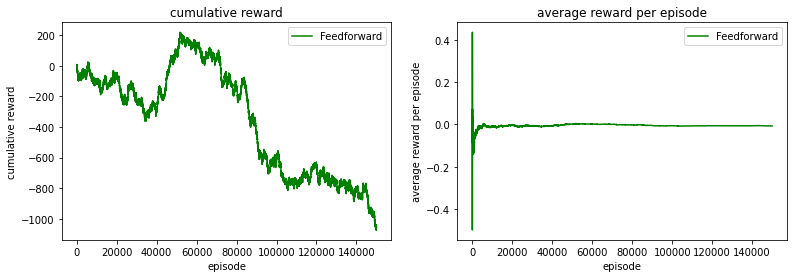

In [4]:
#@title train and collect data: With memory
n_total_episodes = 150000
n_recording_episodes = 5000
n_neurons = 80
len_delay = 39
lr = 0.0001


# initialize environments and agents
#env_lstm = TunlEnv(len_delay)
env_fc = TunlEnv(len_delay)
#env_gru = TunlEnv(len_delay)
#architecture_lstm = [['lstm','linear'], [n_neurons,n_neurons]]
architecture_fc = [['linear','linear'], [n_neurons,n_neurons]]
#architecture_gru = [['gru','linear'], [n_neurons,n_neurons]]
#net_lstm = AC_Net(4, 4, 1, architecture_lstm[0], architecture_lstm[1])
net_fc = AC_Net(4, 4, 1, architecture_fc[0], architecture_fc[1])
#net_gru = AC_Net(4, 4, 1, architecture_gru[0], architecture_gru[1])
#optimizer_lstm = torch.optim.Adam(net_lstm.parameters(), lr)
optimizer_fc = torch.optim.Adam(net_fc.parameters(), lr)
#optimizer_gru = torch.optim.Adam(net_gru.parameters(), lr)


#for name, param in net_lstm.hidden[0].named_parameters(): # Freeze LSTM layer
#  param.requires_grad = False

total_resp_fc, total_sample_identity_fc, total_first_decision_fc, result_dict_fc = train_and_collect(env_fc, net_fc, optimizer_fc)
plot_performance_one_dict(result_dict_fc, 'Feedforward')

In [ ]:
#@title train and collect data: No memory
n_total_episodes = 150000
n_recording_episodes = 5000
n_neurons = 80
len_delay = 39
lr = 0.0001


# initialize environments and agents
env_lstm = TunlEnv_nomem1(len_delay)
#env_fc = TunlEnv_nomem(len_delay)
#env_gru = TunlEnv_nomem(len_delay)
architecture_lstm = [['lstm','linear'], [n_neurons,n_neurons]]
#architecture_fc = [['linear','linear'], [n_neurons,n_neurons]]
#architecture_gru = [['gru','linear'], [n_neurons,n_neurons]]
net_lstm = AC_Net(4, 4, 1, architecture_lstm[0], architecture_lstm[1])
#net_fc = AC_Net(4, 4, 1, architecture_fc[0], architecture_fc[1])
#net_gru = AC_Net(4, 4, 1, architecture_gru[0], architecture_gru[1])
optimizer_lstm = torch.optim.Adam(net_lstm.parameters(), lr)
#optimizer_fc = torch.optim.Adam(net_fc.parameters(), lr)
#optimizer_gru = torch.optim.Adam(net_gru.parameters(), lr)

total_resp_lstm, total_sample_identity_lstm, total_first_decision_lstm, result_dict_lstm= train_and_collect(env_lstm, net_lstm, optimizer_lstm)
plot_performance_one_dict(result_dict_lstm, 'LSTM')

In [ ]:
#@title Initial result count of  network
n_bins = n_total_episodes // n_recording_episodes
for i_bin in [0,9,19]:
  print('Bin: ',i_bin)
  trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm = remove_incomplete(total_resp_lstm[i_bin], total_sample_identity_lstm[i_bin], total_first_decision_lstm[i_bin])
  left_resp_lstm, right_resp_lstm, correct_resp_lstm, incorrect_resp_lstm, count_lstm = split_and_count(trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm)
  print(count_lstm)

Bin:  0
Bin:  1
Bin:  2
Bin:  3
Bin:  4
Bin:  5
Bin:  6
Bin:  7
Bin:  8
Bin:  9
Bin:  10
Bin:  11
Bin:  12
Bin:  13
Bin:  14
Bin:  15
Bin:  16
Bin:  17
Bin:  18
Bin:  19
Bin:  20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:703: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Bin:  21
Bin:  22
Bin:  23
Bin:  24
Bin:  25
Bin:  26
Bin:  27
Bin:  28
Bin:  29


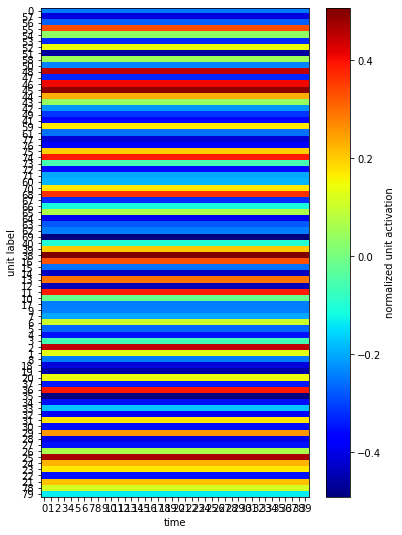

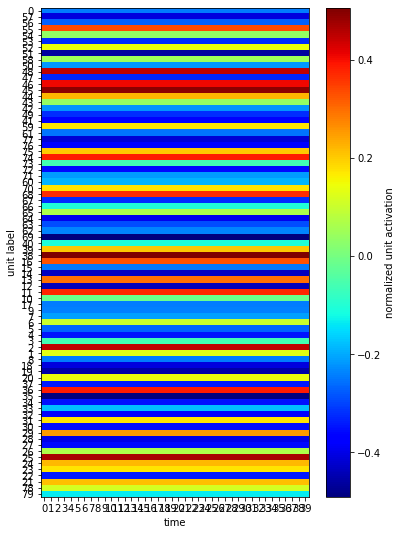

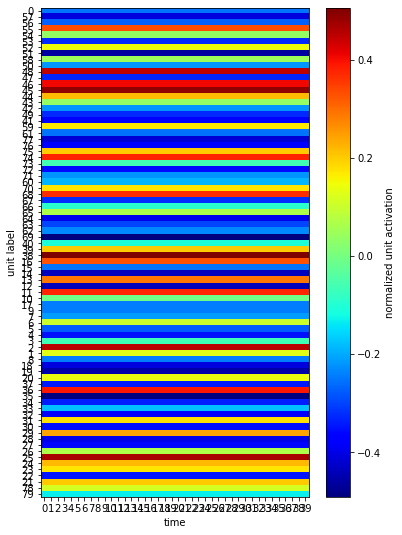

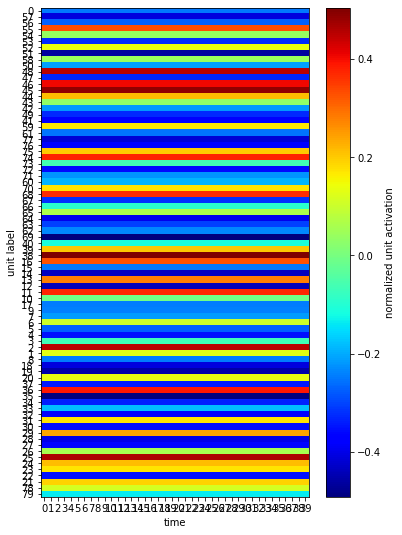

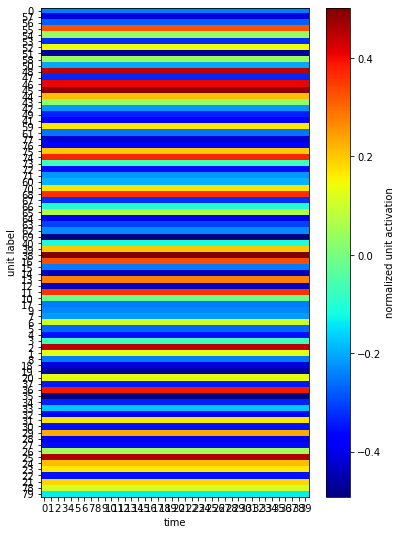

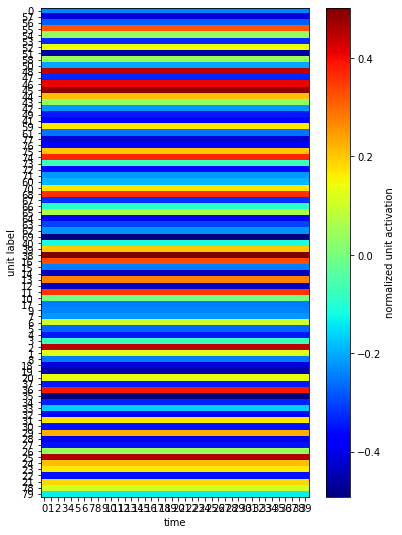

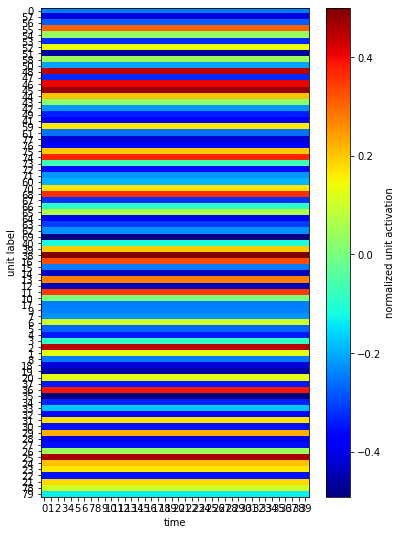

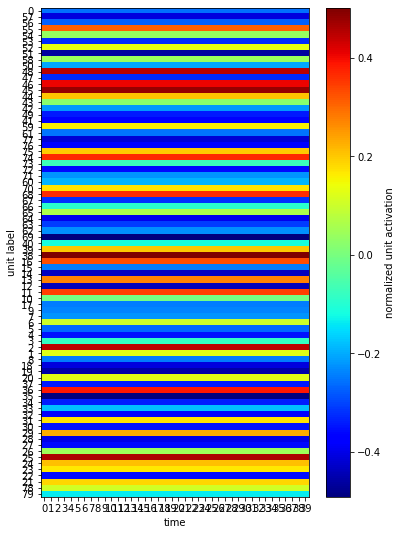

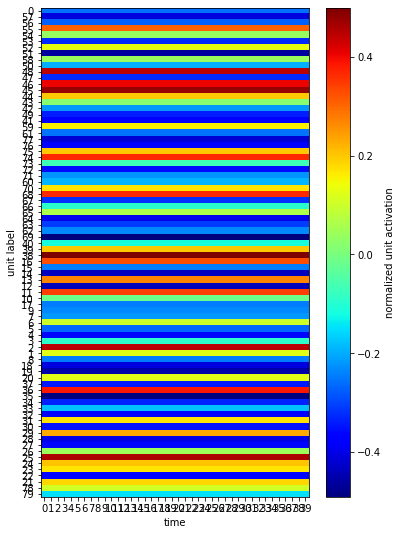

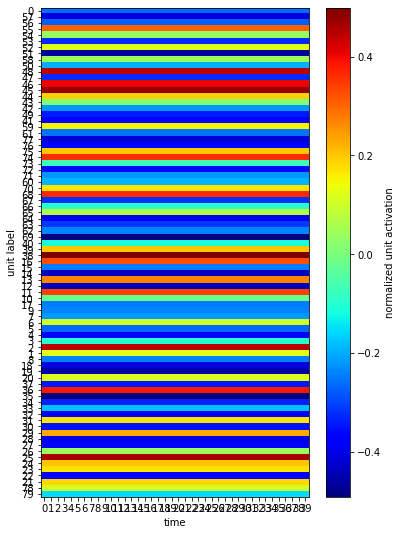

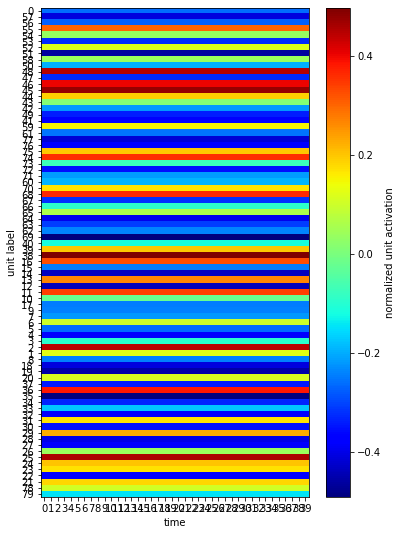

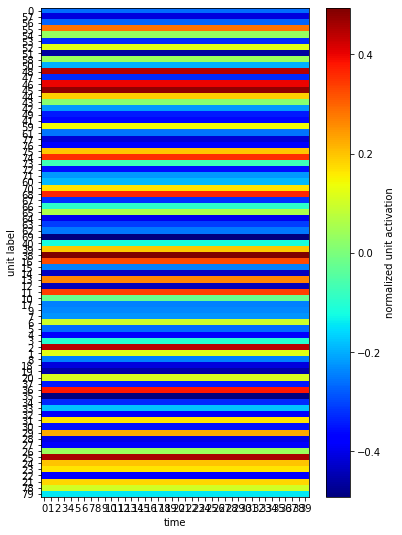

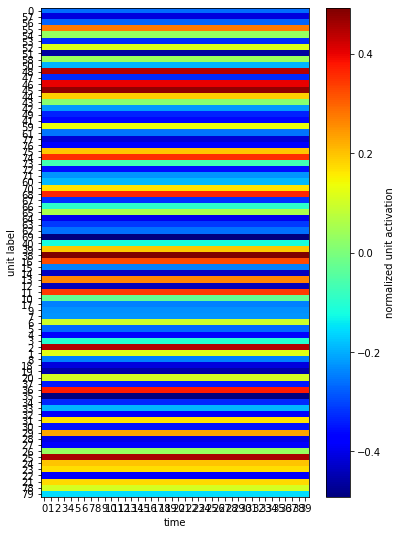

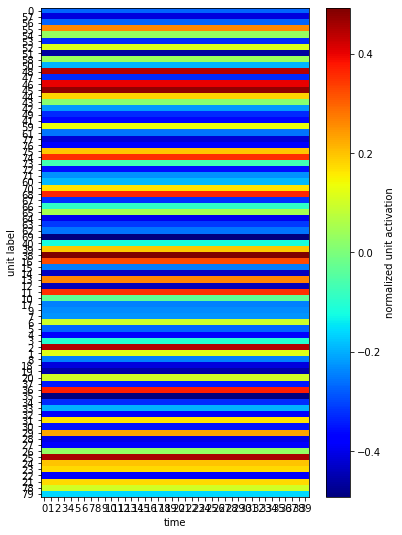

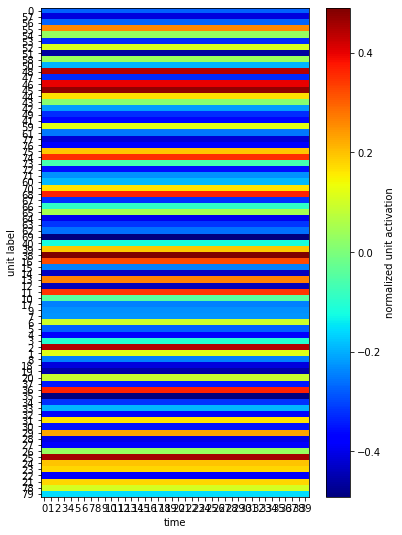

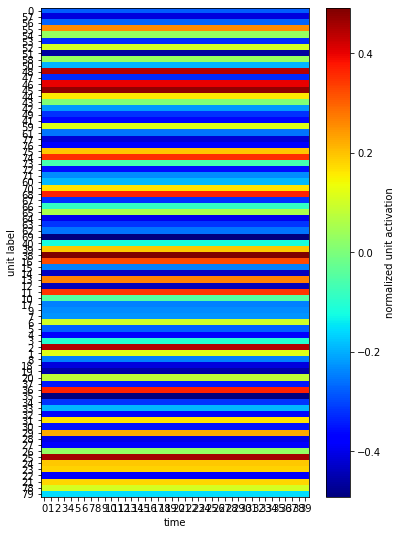

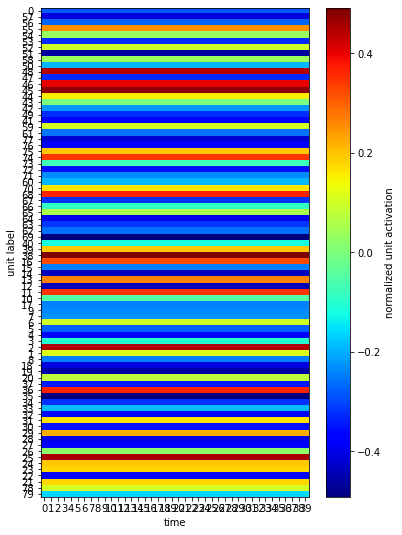

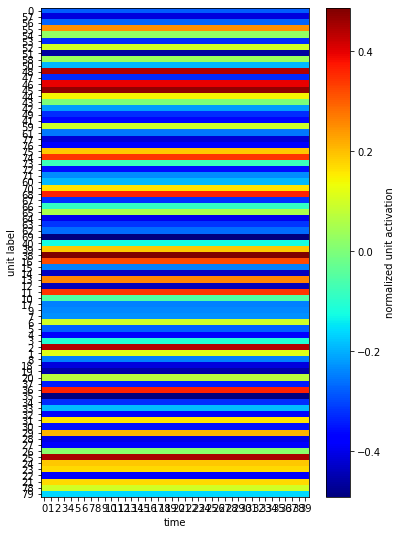

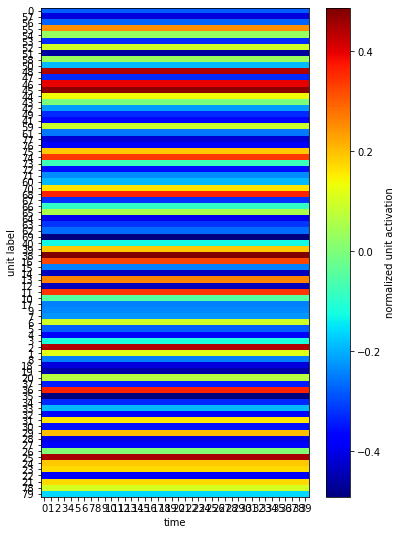

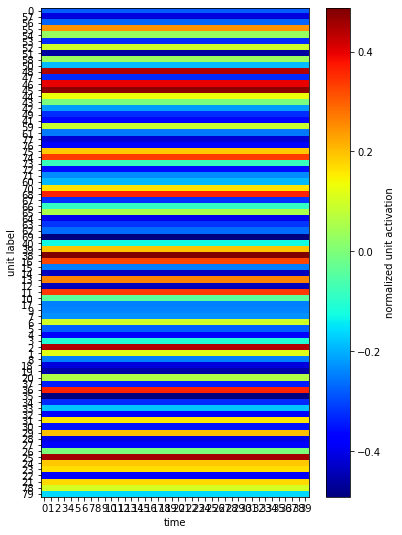

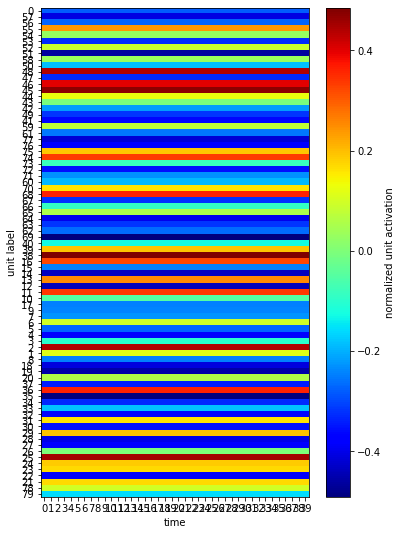

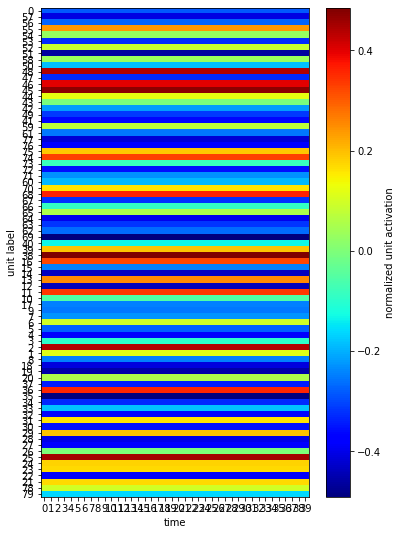

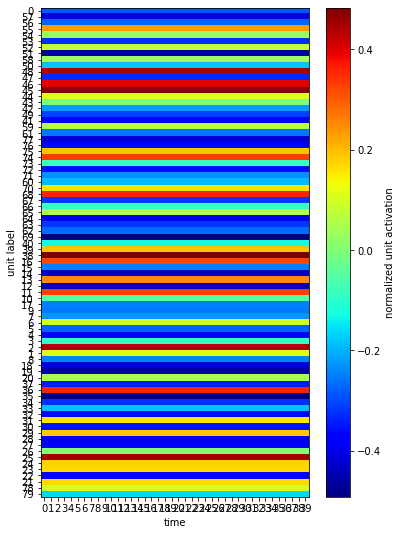

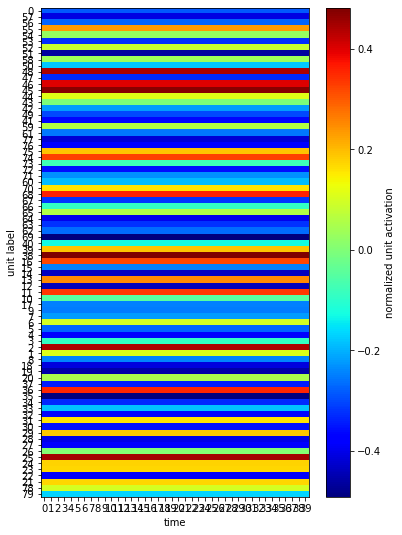

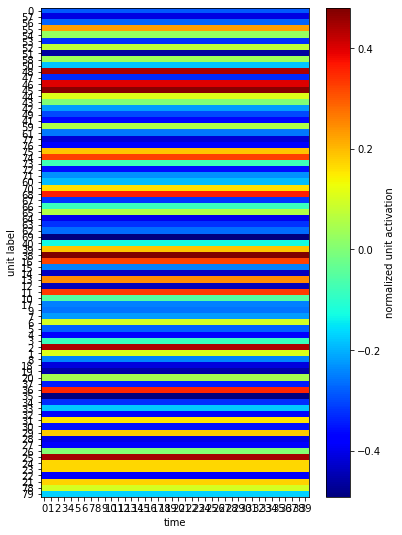

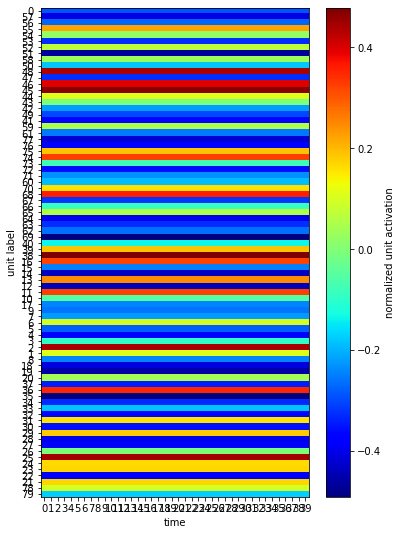

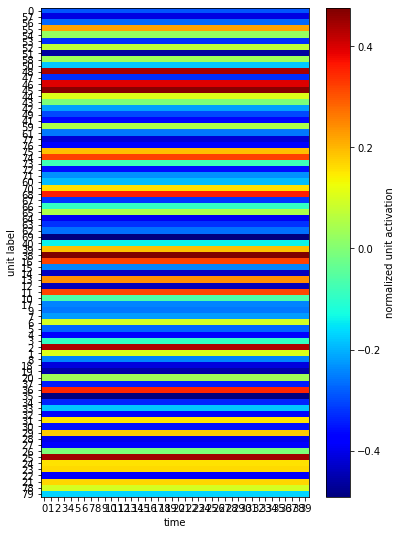

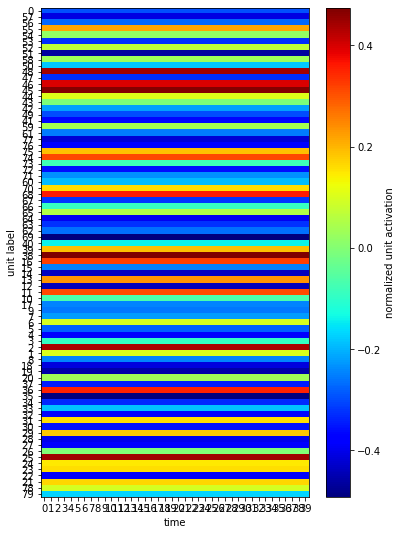

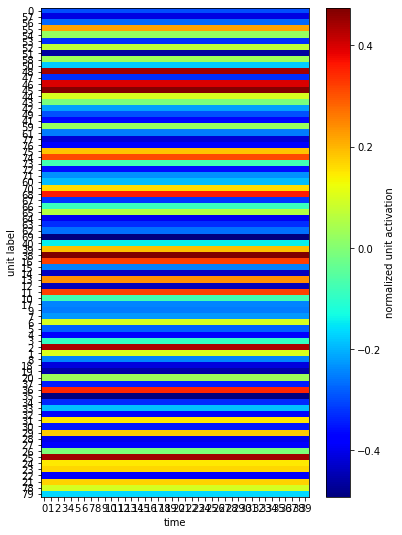

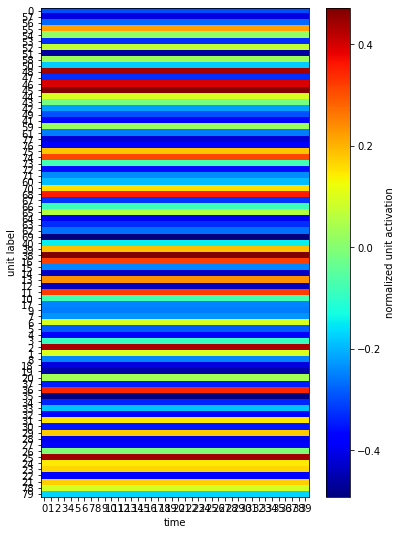

In [8]:
#@tite Visualization: total
n_bins = n_total_episodes // n_recording_episodes
for i_bin in range(n_bins):
  print('Bin: ',i_bin)
  trimmed_resp_fc, trimmed_stim_fc, trimmed_first_decision_fc = remove_incomplete(total_resp_fc[i_bin], total_sample_identity_fc[i_bin], total_first_decision_fc[i_bin])
  left_resp_fc, right_resp_fc, correct_resp_fc, incorrect_resp_fc, count_fc = split_and_count(trimmed_resp_fc, trimmed_stim_fc, trimmed_first_decision_fc)
  #plot_resp_and_stim(trimmed_resp_lstm, trimmed_stim_lstm, len_delay)
  plot_sorted_averaged_resp(trimmed_resp_fc, len_delay, n_neurons, norm=False)

In [ ]:
#@title visualization - L v R
n_bins = n_total_episodes // n_recording_episodes
for i_bin in range(n_bins):
  print('Bin: ',i_bin)
  trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm = remove_incomplete(total_resp_lstm[i_bin], total_sample_identity_lstm[i_bin], total_first_decision_lstm[i_bin])
  left_resp_lstm, right_resp_lstm, correct_resp_lstm, incorrect_resp_lstm, count_lstm = split_and_count(trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm)
  plot_sorted_in_same_order(left_resp_lstm, right_resp_lstm, 'left', 'right', len_delay, n_neurons)

In [ ]:
#@title visualization - R v L
n_bins = n_total_episodes // n_recording_episodes
for i_bin in range(n_bins):
  print('Bin: ',i_bin)
  trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm = remove_incomplete(total_resp_lstm[i_bin], total_sample_identity_lstm[i_bin], total_first_decision_lstm[i_bin])
  left_resp_lstm, right_resp_lstm, correct_resp_lstm, incorrect_resp_lstm, count_lstm = split_and_count(trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm)
  plot_sorted_in_same_order(right_resp_lstm, left_resp_lstm, 'right', 'left', len_delay, n_neurons)

In [ ]:
#@title visualization - correct v incorrect
n_bins = n_total_episodes // n_recording_episodes
for i_bin in range(n_bins):
  print('Bin: ',i_bin)
  trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm = remove_incomplete(total_resp_lstm[i_bin], total_sample_identity_lstm[i_bin], total_first_decision_lstm[i_bin])
  left_resp_lstm, right_resp_lstm, correct_resp_lstm, incorrect_resp_lstm, count_lstm = split_and_count(trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm)
  plot_sorted_in_same_order(correct_resp_lstm, incorrect_resp_lstm, 'correct', 'incorrect', len_delay, n_neurons)

In [11]:
#@title Decode sample from entire delay
for i_bin in range(n_bins):
  print('Bin: ', i_bin)
  trimmed_resp_fc, trimmed_stim_fc, trimmed_first_decision_fc = remove_incomplete(total_resp_fc[i_bin], total_sample_identity_fc[i_bin], total_first_decision_fc[i_bin])
  decode_sample_from_delay(trimmed_resp_fc, trimmed_stim_fc, percent_train=0.6, max_iter=1000) # should print a table

Bin:  0
-------------  ------
unshuffled     0.5085
shuffle time   0.506
shuffle units  0.5235
shuffle both   0.5055
-------------  ------
Bin:  1
-------------  ------
unshuffled     0.5205
shuffle time   0.4955
shuffle units  0.4815
shuffle both   0.482
-------------  ------
Bin:  2
-------------  ------
unshuffled     0.507
shuffle time   0.496
shuffle units  0.4895
shuffle both   0.495
-------------  ------
Bin:  3
-------------  ------
unshuffled     0.483
shuffle time   0.5255
shuffle units  0.507
shuffle both   0.496
-------------  ------
Bin:  4
-------------  ------
unshuffled     0.5125
shuffle time   0.4955
shuffle units  0.507
shuffle both   0.511
-------------  ------
Bin:  5
-------------  ------
unshuffled     0.508
shuffle time   0.5
shuffle units  0.5115
shuffle both   0.5005
-------------  ------
Bin:  6
-------------  -----
unshuffled     0.509
shuffle time   0.503
shuffle units  0.514
shuffle both   0.506
-------------  -----
Bin:  7
-------------  ------
unshuffled

In [ ]:
#@title Decode sample from single timepoint
for i_bin in [0,4,8,13,19]:
  print('Bin: ', i_bin)
  trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm = remove_incomplete(total_resp_lstm[i_bin], total_sample_identity_lstm[i_bin], total_first_decision_lstm[i_bin])
  plot_decode_sample_from_single_time_one_resp(trimmed_resp_lstm, trimmed_stim_lstm, 'lstm', max_iter=10000)


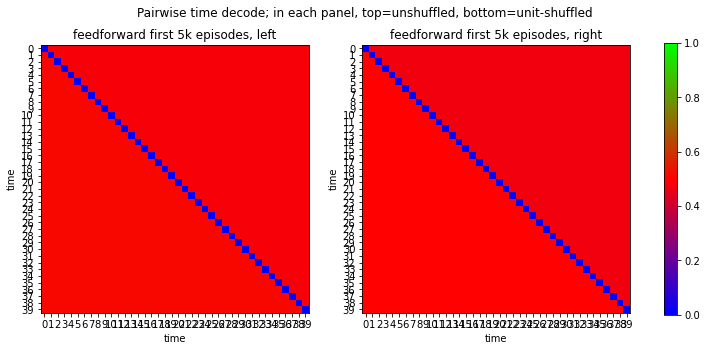

In [12]:
#@title Pairwise time decode - beginning
i_bin=0
trimmed_resp_fc, trimmed_stim_fc, trimmed_first_decision_fc = remove_incomplete(total_resp_fc[i_bin], total_sample_identity_fc[i_bin], total_first_decision_fc[i_bin])
left_resp_fc, right_resp_fc, correct_resp_fc, incorrect_resp_fc, count_fc = split_and_count(trimmed_resp_fc, trimmed_stim_fc, trimmed_first_decision_fc)
plot_pairwise_time_decode_one_resp(left_resp_fc, right_resp_fc, 'feedforward first 5k episodes', max_iter=10000)

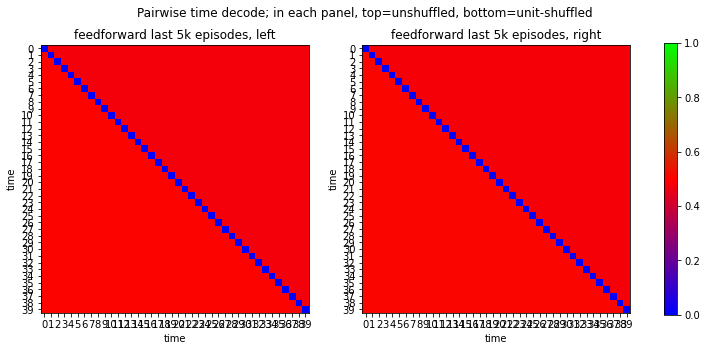

In [13]:
#@title pairwise time decode - end
i_bin=29
trimmed_resp_fc, trimmed_stim_fc, trimmed_first_decision_fc = remove_incomplete(total_resp_fc[i_bin], total_sample_identity_fc[i_bin], total_first_decision_fc[i_bin])
left_resp_fc, right_resp_fc, correct_resp_fc, incorrect_resp_fc, count_fc = split_and_count(trimmed_resp_fc, trimmed_stim_fc, trimmed_first_decision_fc)
plot_pairwise_time_decode_one_resp(left_resp_fc, right_resp_fc, 'feedforward last 5k episodes', max_iter=10000)

Bin:  0
[0.77270245 0.15382304 0.02359606]
Bin:  1
[0.50618677 0.30760281 0.07627845]
Bin:  2
[0.51648048 0.19744459 0.13754405]
Bin:  3
[0.45871509 0.26592417 0.10694616]
Bin:  4
[0.52532566 0.22613184 0.09117098]
Bin:  5
[0.73057677 0.11072024 0.08436649]
Bin:  6
[0.34136982 0.32081639 0.14276681]
Bin:  7
[0.68321306 0.16590596 0.05083477]
Bin:  8
[0.43436108 0.35984529 0.10359952]
Bin:  9
[0.61286826 0.21000058 0.07166231]
Bin:  10
[0.52523404 0.24888657 0.08378916]
Bin:  11
[0.60592336 0.22533577 0.07081903]
Bin:  12
[0.51865569 0.2849865  0.07750616]
Bin:  13
[0.57426388 0.18340379 0.0983233 ]
Bin:  14
[0.45349993 0.4131945  0.0621947 ]
Bin:  15
[0.45797516 0.32384502 0.09661868]
Bin:  16
[0.65706882 0.20838521 0.03840759]
Bin:  17
[0.50066985 0.26132424 0.09930456]
Bin:  18
[0.56943758 0.24557349 0.07357386]
Bin:  19
[0.51470023 0.32259193 0.05360986]
Bin:  20
[0.50079924 0.28477148 0.10663316]
Bin:  21


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1182: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[0.40706322 0.26124315 0.13160461]
Bin:  22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1182: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[0.54631406 0.25914999 0.07848539]
Bin:  23


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1182: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[0.477579   0.25699633 0.14885409]
Bin:  24


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1182: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[0.56063336 0.29700399 0.06841574]
Bin:  25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1182: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[0.50335015 0.22192054 0.13416134]
Bin:  26


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1182: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[0.43228248 0.3767437  0.06064756]
Bin:  27


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1182: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[0.44259107 0.28465147 0.13263494]
Bin:  28


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1182: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[0.68472306 0.1474046  0.061985  ]
Bin:  29


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1182: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[0.4578062  0.21714597 0.11483226]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1182: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


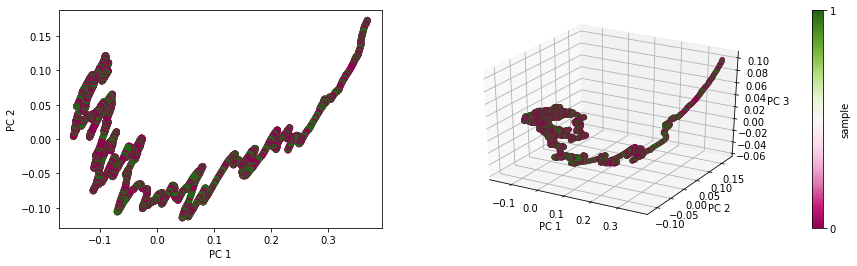

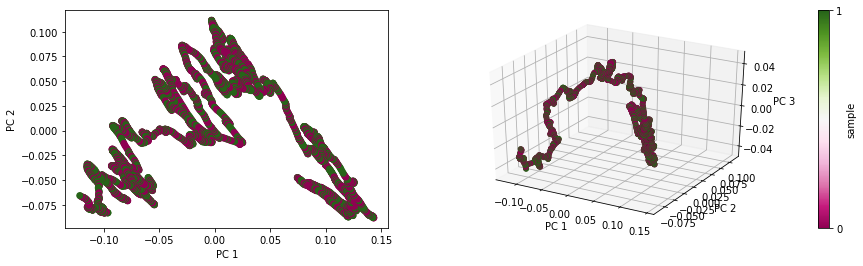

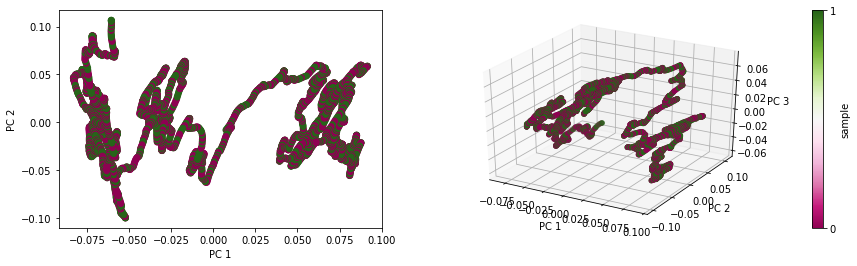

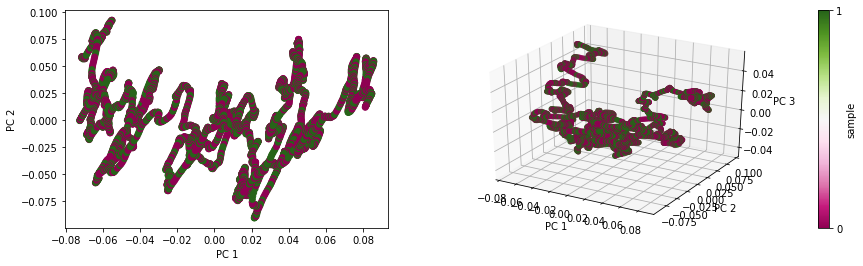

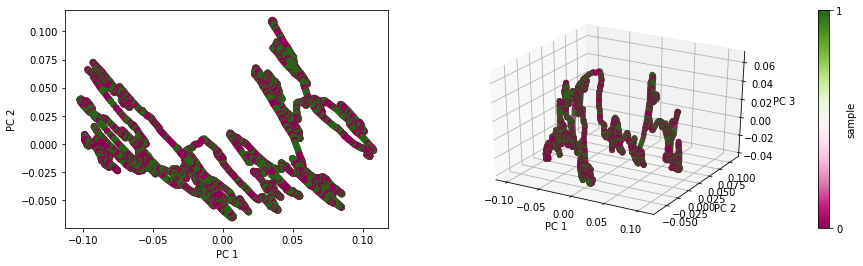

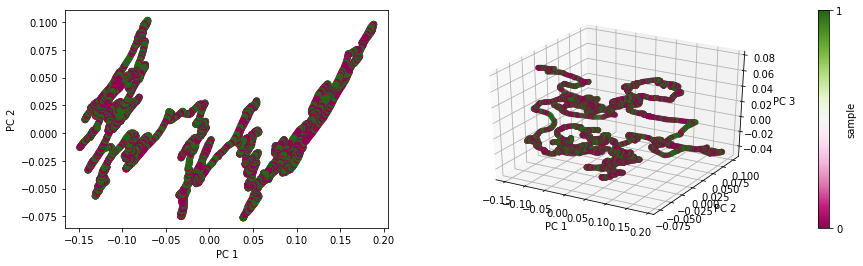

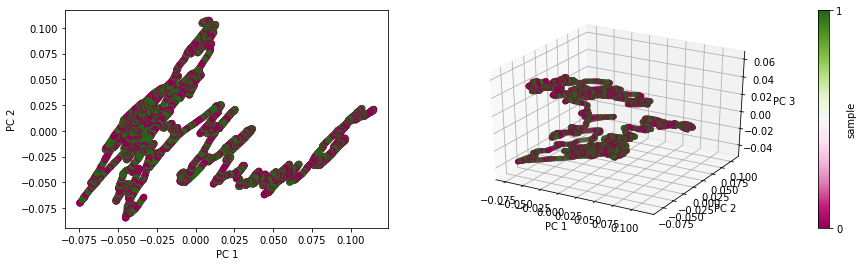

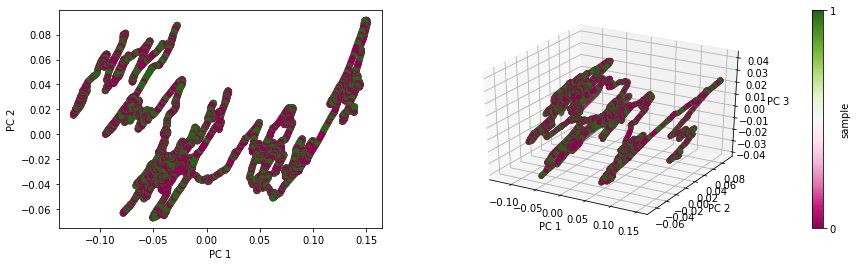

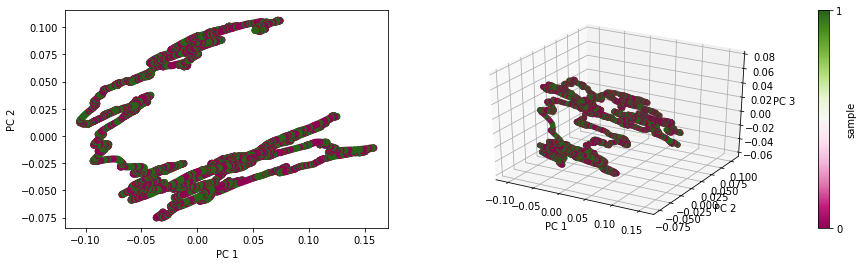

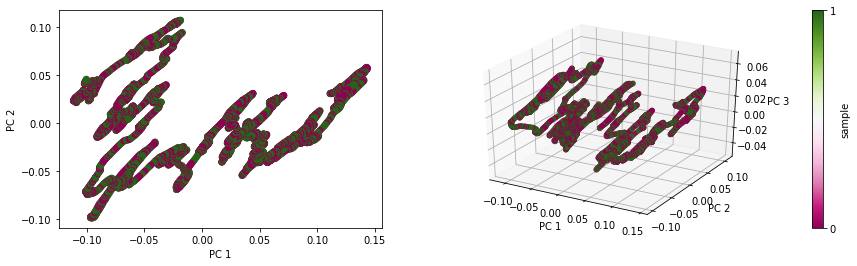

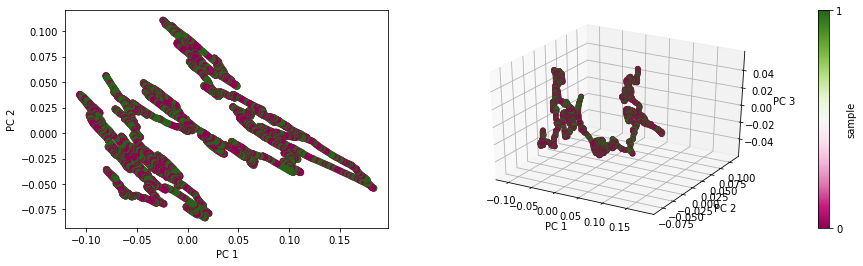

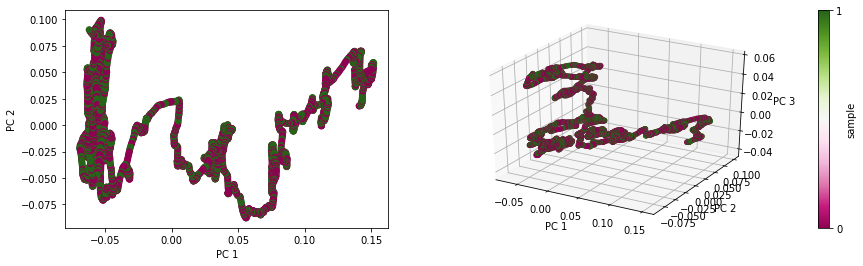

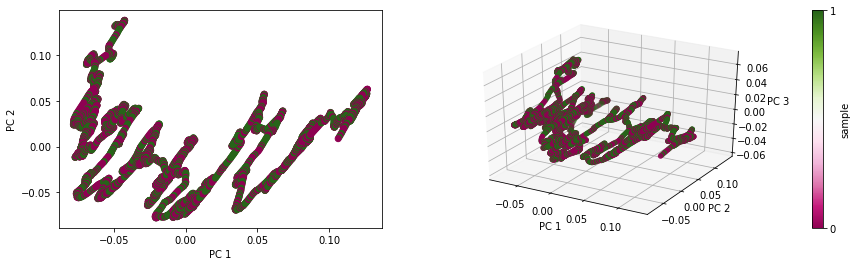

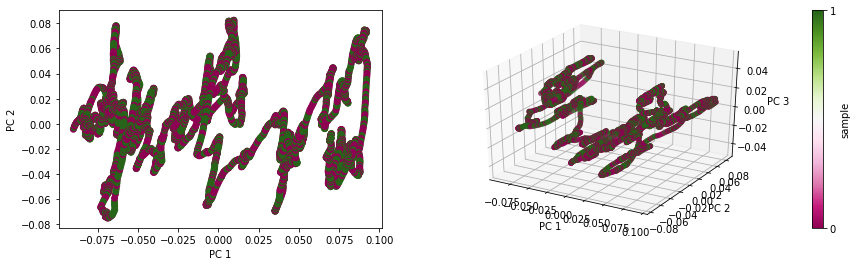

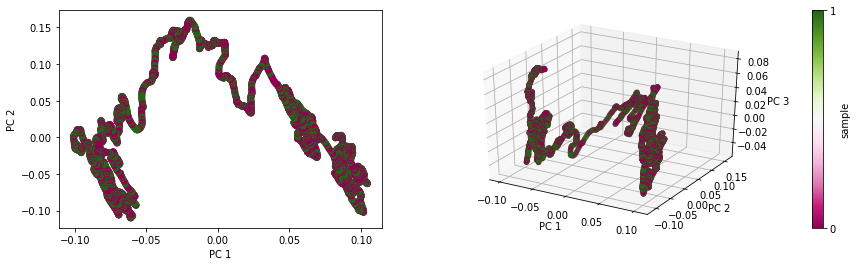

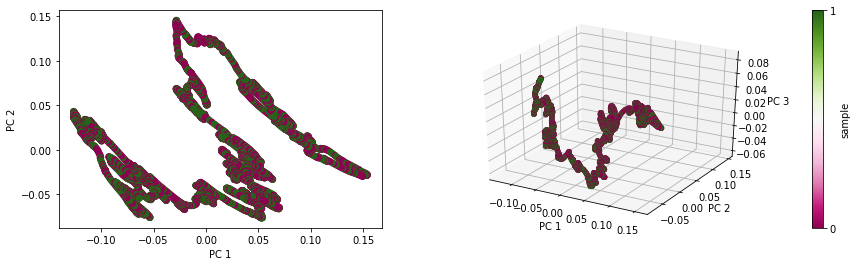

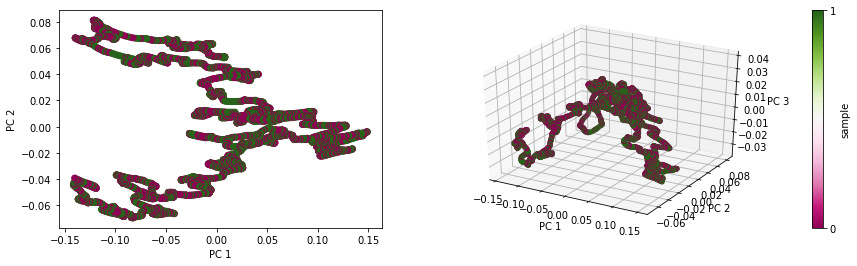

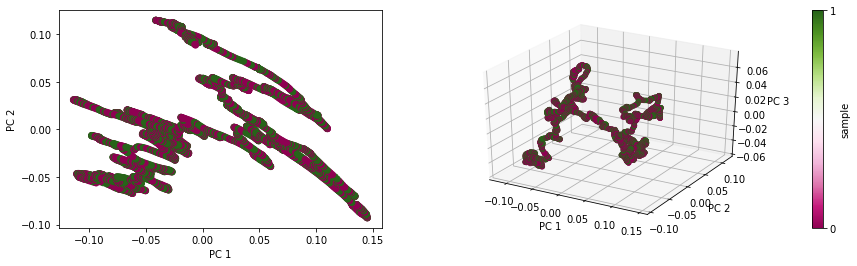

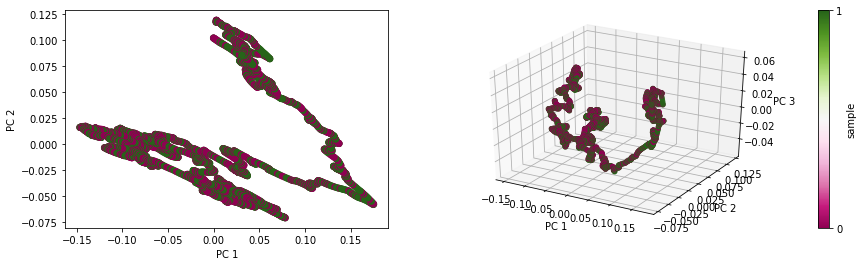

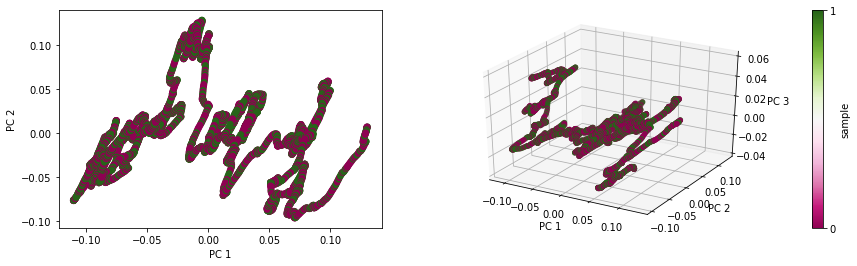

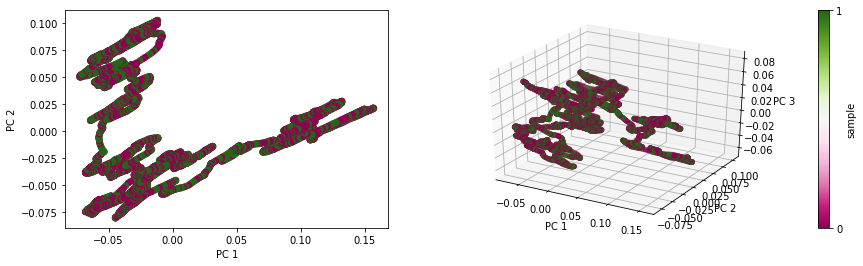

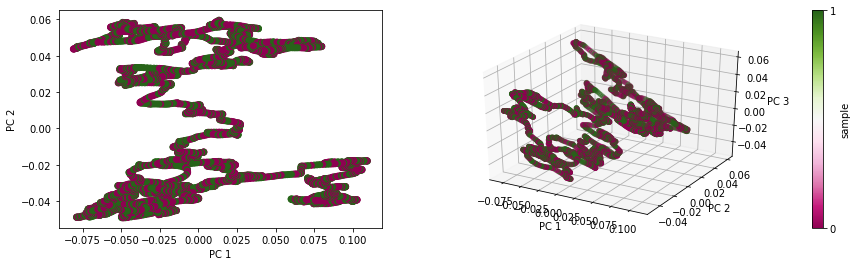

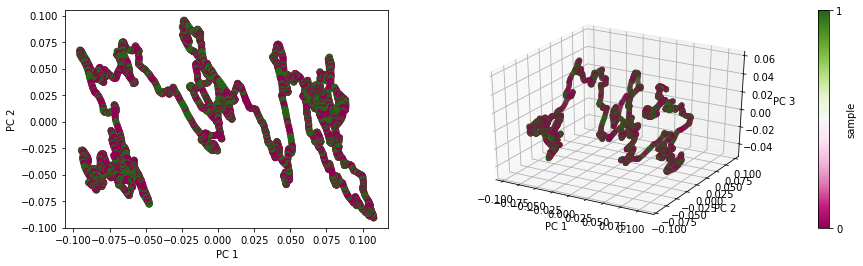

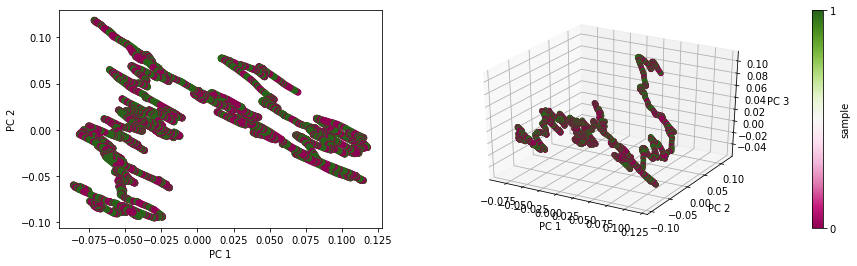

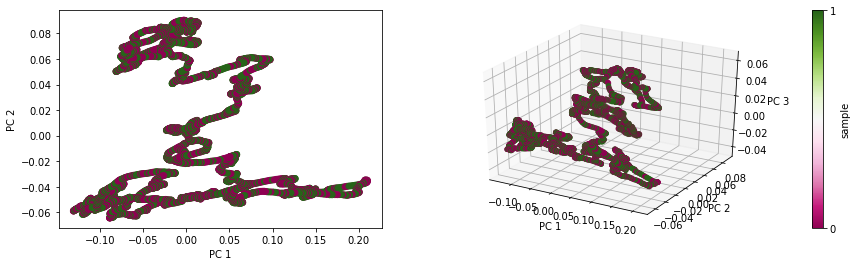

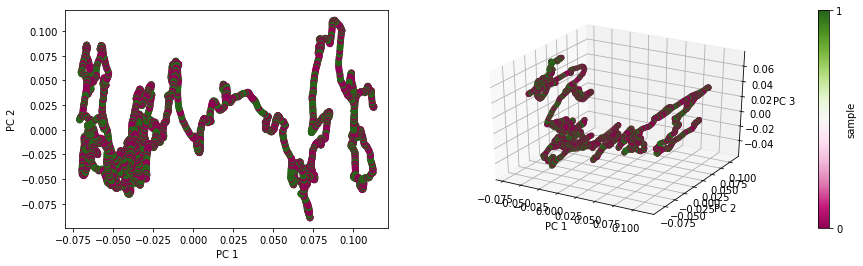

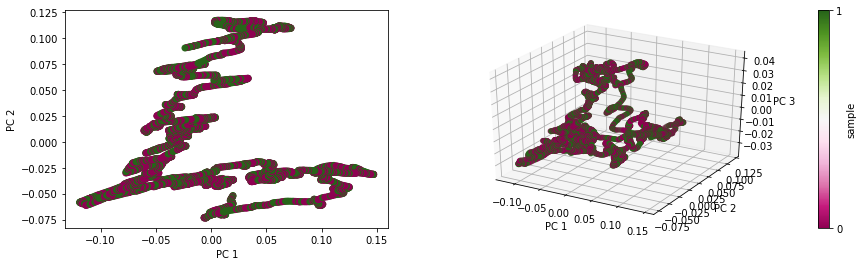

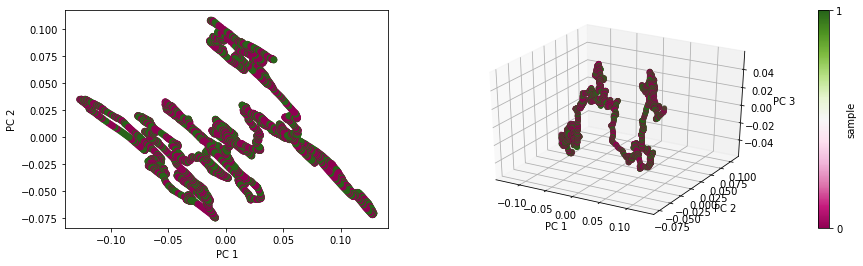

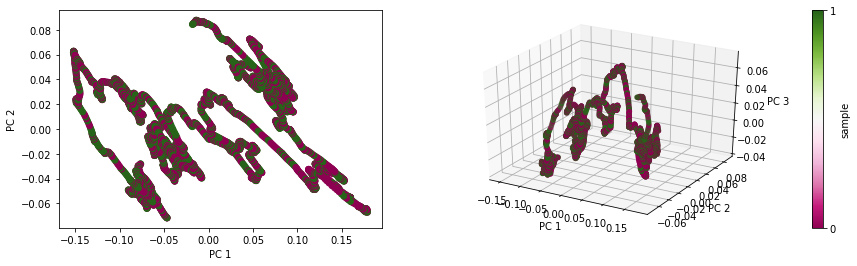

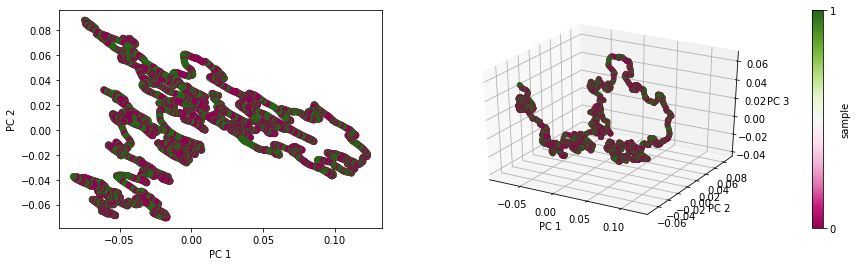

In [9]:
#@title PCA Visualization
for i_bin in range(n_bins):
  print('Bin: ', i_bin)
  trimmed_resp_fc, trimmed_stim_fc, trimmed_first_decision_fc = remove_incomplete(total_resp_fc[i_bin], total_sample_identity_fc[i_bin], total_first_decision_fc[i_bin])
  pca_analysis(trimmed_resp_fc, trimmed_stim_fc) 

Bin:  0


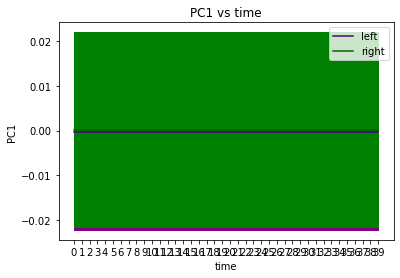

Bin:  1


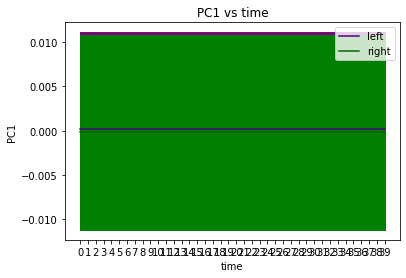

Bin:  2


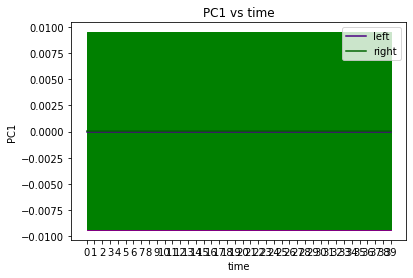

Bin:  3


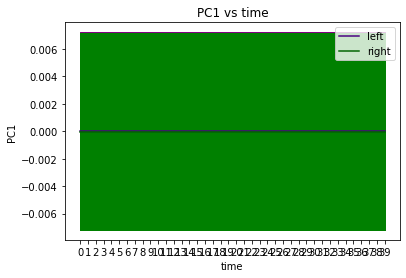

Bin:  4


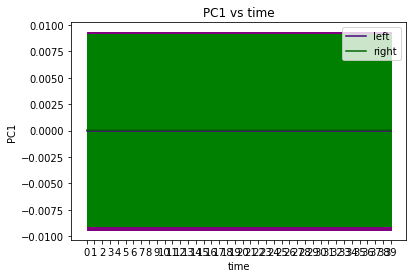

Bin:  5


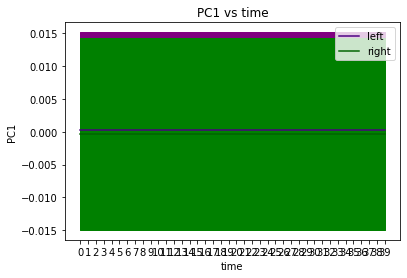

Bin:  6


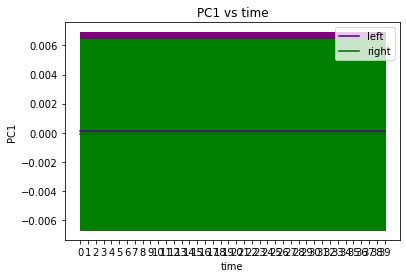

Bin:  7


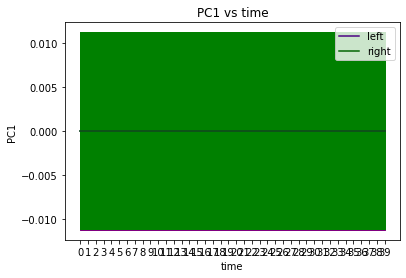

Bin:  8


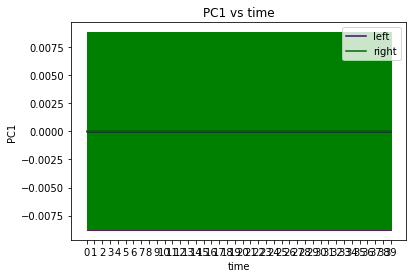

Bin:  9


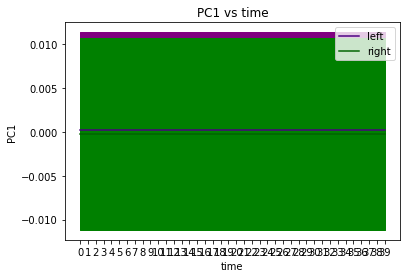

Bin:  10


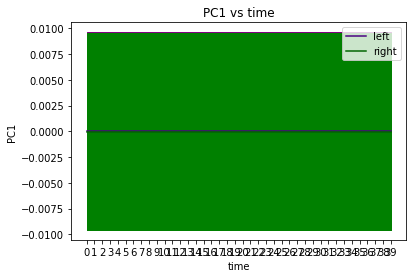

Bin:  11


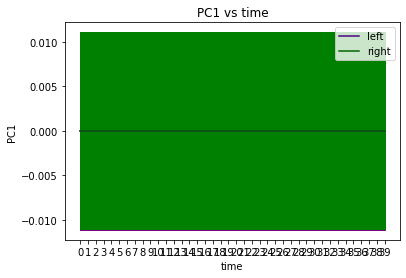

Bin:  12


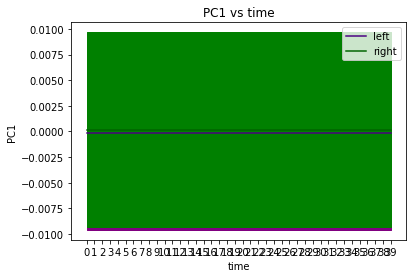

Bin:  13


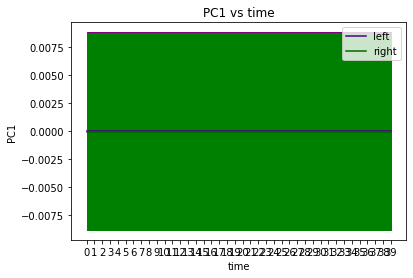

Bin:  14


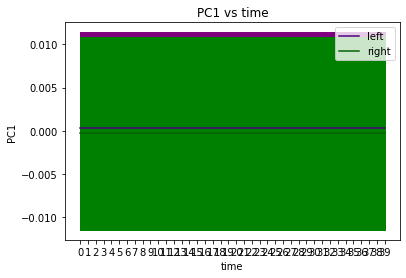

Bin:  15


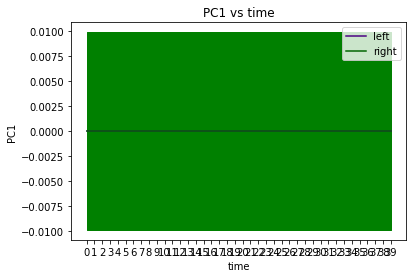

Bin:  16


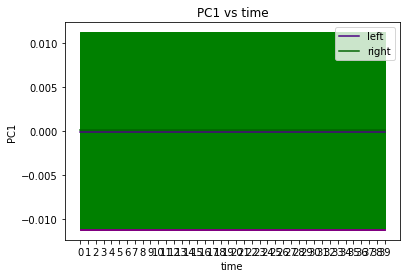

Bin:  17


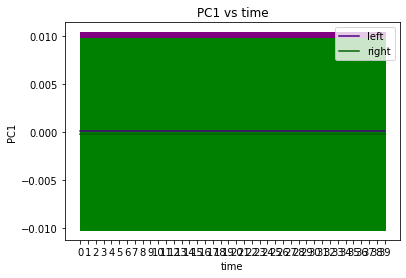

Bin:  18


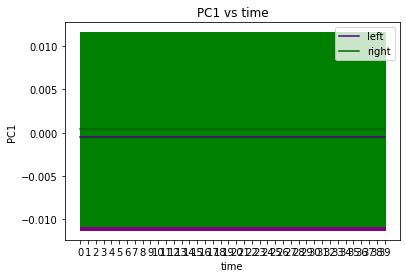

Bin:  19


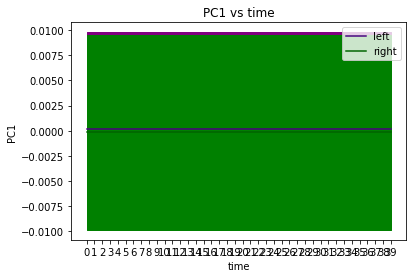

Bin:  20


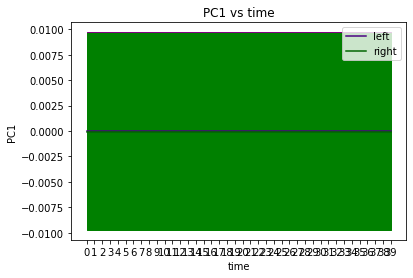

Bin:  21


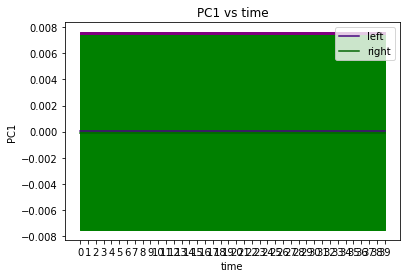

Bin:  22


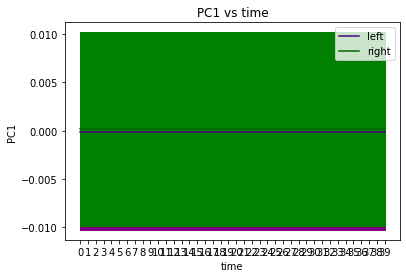

Bin:  23


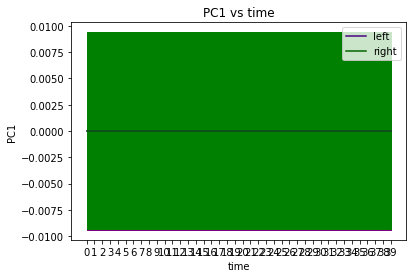

Bin:  24


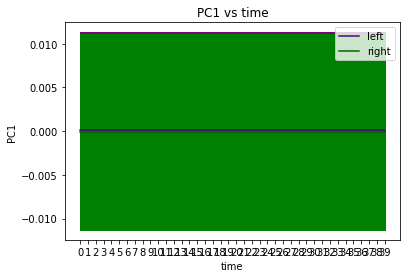

Bin:  25


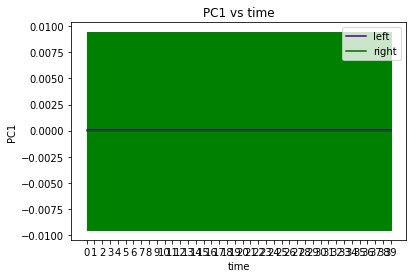

Bin:  26


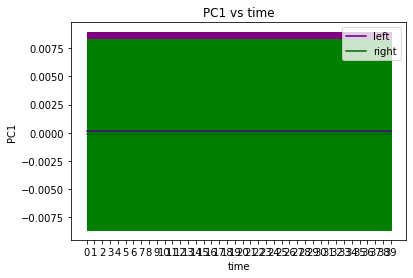

Bin:  27


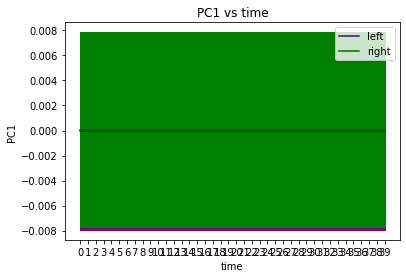

Bin:  28


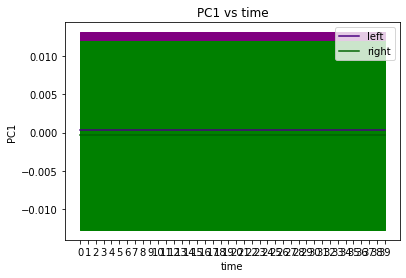

Bin:  29


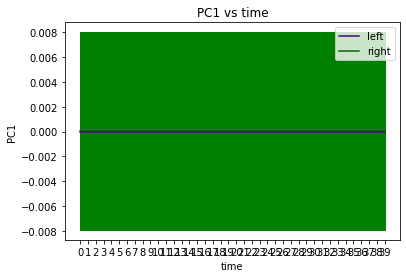

In [10]:
#@title PC1 vs. time
for i_bin in range(n_bins):
  print('Bin: ', i_bin)
  trimmed_resp_fc, trimmed_stim_fc, trimmed_first_decision_fc = remove_incomplete(total_resp_fc[i_bin], total_sample_identity_fc[i_bin], total_first_decision_fc[i_bin])
  plot_pc1_vs_time(trimmed_resp_fc, trimmed_stim_fc)

In [ ]:
#@title average activation vs. time
for i_bin in range(n_bins):
  print('Bin: ', i_bin)
  trimmed_resp_gru, trimmed_stim_gru, trimmed_first_decision_gru = remove_incomplete(total_resp_gru[i_bin], total_sample_identity_gru[i_bin], total_first_decision_gru[i_bin])
  plot_avg_act_vs_time(trimmed_resp_gru, trimmed_stim_gru, norm=False)

In [ ]:
#@title single cell - 1
i_bin=19
trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm = remove_incomplete(total_resp_lstm[i_bin], total_sample_identity_lstm[i_bin], total_first_decision_lstm[i_bin])
left_resp_lstm, right_resp_lstm, correct_resp_lstm, incorrect_resp_lstm, count_lstm = split_and_count(trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm)
plot_single_unit(right_resp_lstm, n_display=100, norm=False)

In [ ]:
#@title single cell evolution - 1
i_neuron=0
n_display=100
for i_bin in range(n_bins):
  trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm = remove_incomplete(total_resp_lstm[i_bin], total_sample_identity_lstm[i_bin], total_first_decision_lstm[i_bin])
  left_resp_lstm, right_resp_lstm, correct_resp_lstm, incorrect_resp_lstm, count_lstm = split_and_count(trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm)
  resp = left_resp_lstm###
  x = resp[:, np.arange(start=i_neuron,stop=resp.shape[1],step=n_neurons)] # extract columns that belong to this neuron
  fig = plt.figure(figsize=(5,5))
  fig.suptitle(f'neuron {i_neuron}, bin {i_bin}, sample=L')###
  gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])
  ax1 = plt.subplot(gs[0])
  im=ax1.imshow(x[-n_display:],cmap='jet')
  ax1.set_aspect('auto')
  ax1.set_title('unit activation')
  ax1.set_xticks(np.arange(len_delay+1))
  ax1.set_yticks([])
  ax1.set_ylabel(f'episode (shown last {n_display} of bin {i_bin})')
  ax2 = plt.subplot(gs[1])
  ax2.plot(np.arange(len_delay+1), np.mean(x, axis=0),'-o')
  ax2.set_xlabel('time')
  ax2.set_ylabel(f'averaged activation of bin {i_bin}')
  plt.show()

In [ ]:
#@title single cell evolution - 2
i_neuron=0
n_display=100
for i_bin in range(n_bins):
  trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm = remove_incomplete(total_resp_lstm[i_bin], total_sample_identity_lstm[i_bin], total_first_decision_lstm[i_bin])
  left_resp_lstm, right_resp_lstm, correct_resp_lstm, incorrect_resp_lstm, count_lstm = split_and_count(trimmed_resp_lstm, trimmed_stim_lstm, trimmed_first_decision_lstm)
  resp = right_resp_lstm###
  x = resp[:, np.arange(start=i_neuron,stop=resp.shape[1],step=n_neurons)] # extract columns that belong to this neuron
  fig = plt.figure(figsize=(5,5))
  fig.suptitle(f'neuron {i_neuron}, bin {i_bin}, sample=R')###
  gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])
  ax1 = plt.subplot(gs[0])
  im=ax1.imshow(x[-n_display:],cmap='jet')
  ax1.set_aspect('auto')
  ax1.set_title('unit activation')
  ax1.set_xticks(np.arange(len_delay+1))
  ax1.set_yticks([])
  ax1.set_ylabel(f'episode (shown last {n_display} of bin {i_bin})')
  ax2 = plt.subplot(gs[1])
  ax2.plot(np.arange(len_delay+1), np.mean(x, axis=0),'-o')
  ax2.set_xlabel('time')
  ax2.set_ylabel(f'averaged activation of bin {i_bin}')
  plt.show()